<a href="https://colab.research.google.com/github/harnalashok/CatEncodersFamily/blob/main/avazu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
# Last amended: 08th Aug, 2023
# Click through rate prediction
# Experiments have been done on Jupyter Notebook and NOT on colab
# All saved data is available on gdrive for recall and run the expt again from any point
# Data Source: https://www.kaggle.com/competitions/avazu-ctr-prediction/data

"""

In [ ]:
"""
# THIS FILE IS NAMED AS PER THE DATASIZE READ: 50lakh observations
"""

In [60]:
# -0.2 WARN Will delete all earlier work

#   Delete talkingdatafolder, if it exists
#   Cleanup earlier saved data:

talkingdata = Path("D:\\talkingdata\\allmodels")

if talkingdatafolder.exists():
    shutil.rmtree(talkingdata)

## Basics

In [2]:
# -0.1
! pip install tabulate

Defaulting to user installation because normal site-packages is not writeable


In [3]:
# 0.1
%reset
!pip install catencfamily==0.0.89

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Defaulting to user installation because normal site-packages is not writeable


In [4]:
# 1.0 Call libraries
import pandas as pd
import numpy as np
import gc,time




# 1.0.1
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.manifold import  TSNE
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report,f1_score,roc_auc_score

# 1.0.2
import networkx as nx
from networkx import community

# 1.0.3
import matplotlib.pyplot as plt
#import plotly.express as px
import seaborn as sns

# 1.0.4
import xgboost as xgb
from catencfamily.encoders import CatEncodersFamily
from catencfamily import utils


# 1.0.5
import shutil
from pathlib import Path
import itertools
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

Note: to be able to use all crisp methods, you need to install some additional packages:  {'leidenalg', 'graph_tool', 'infomap', 'karateclub', 'wurlitzer'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'ASLPAw', 'karateclub'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'infomap', 'wurlitzer', 'leidenalg'}


In [5]:
# 1.0.6 Display multiple commands output from a cell:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [6]:
# 1.0.7 Decide program-wide random state:

rng= np.random.RandomState(None)

In [7]:
# 1.0.8 Folders where outputs will be saved:

talkingdata = Path("D:\\talkingdata\\allmodels")

talkingdatagraphs = talkingdata / "models"     # For graph files
talkingdatadata = talkingdata / "datafiles"    # For data files
talkingdataestimators = talkingdata / "estimators"  # For fitted estimators
talkingdataunitvecs = talkingdata  / "unitvec"      # For unitvectors

## Taking a sample of data


In [66]:
## 1.1 We will extract data randomly from disk using the following code

dataPath = "D:\\talkingData\\"

dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
    }


print('load train...')


# 1.2 Read a fraction of data
total_lines = 184903891 # Total size of data
read_lines =   5000000  # 50L/40lakh/20lakh small

# 1.3 Read randomly 'p' fraction of files
#     Ref: https://stackoverflow.com/a/48589768

p = read_lines/total_lines  # fraction of lines to read

parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')
train = pd.read_csv(
                     dataPath + "train.csv.zip",  
                     header=0,  
                     skiprows=lambda i: (i >0 ) and (np.random.random() > p),   
                     dtype=dtypes,
                     usecols=['ip','app','device','os', 'channel', 'click_time', 'attributed_time', 'is_attributed'],
                     parse_dates=['click_time'],
                    )   # Takes 3minutes


load train...


In [67]:
# 1.3.1
# Explore read data:
train.shape     # (4996254, 8)
                
train.head(3)
train.dtypes

(4996254, 8)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,124979,3,1,18,379,2017-11-06 14:40:16,NaN,0
1,91749,3,1,19,379,2017-11-06 14:43:51,NaN,0
2,182500,3,1,16,379,2017-11-06 15:41:09,NaN,0


ip                         uint32
app                        uint16
device                     uint16
os                         uint16
channel                    uint16
click_time         datetime64[ns]
attributed_time            object
is_attributed               uint8
dtype: object

### Extract date components

In [68]:
# 1.3.2  Extract date and time information from 'click_time':

train['day'] = train['click_time'].dt.day.astype('uint8')
train['hour'] = train['click_time'].dt.hour.astype('uint8')
train['minute'] = train['click_time'].dt.minute.astype('uint8')
train['second'] = train['click_time'].dt.second.astype('uint8')

In [69]:
# 1.3.3 Renaming target column 'is_attributed' for conveneince:

train = train.rename(columns = {'is_attributed' : 'isattributed'} )

In [70]:
# 1.3.4 Imbalanced data!

train['isattributed'].value_counts()
print("\n")
train['isattributed'].value_counts(normalize = True) # 99.7%:0.24%

0    4983850
1      12404
Name: isattributed, dtype: int64

0    0.997517
1    0.002483
Name: isattributed, dtype: float64

In [71]:
# 2.0 Pop out not needed columns:

_ = train.pop('click_time')
_ = train.pop('attributed_time')

# 2.0.1 Separate target, and drop id
y = train.pop("isattributed")

In [78]:
# 2.1 Here is a list of all columns: 

cols = ['ip', 'app', 'device', 'os', 'channel', 'day', 'hour', 'minute',
       'second']    



# 2.1.1 Check no of unique values
#       Column ip has very large no of unique values

u = []
for i in cols:
    u.append([i,train[i].nunique()])

print(tabulate(u, headers = ["colName", "No of unique values"]))

colName      No of unique values
---------  ---------------------
ip                        126218
app                          377
device                       943
os                           274
channel                      177
day                            4
hour                          24
minute                        60
second                        60


## Partition data

In [79]:
# 3.0 Split our data:

X_train, X_test, y_train, y_test = train_test_split(
                                                    train,
                                                    y,
                                                    test_size = 0.25,
                                                    stratify= y,
                                                    random_state= rng)




# 3.0.1 Check shapes:
X_train.shape    # (3747190, 9)
X_test.shape     # (1249064, 9)
y_train.shape    
y_test.shape     

(3747190, 9)

(1249064, 9)

(3747190,)

(1249064,)

In [80]:
# 3.1 Check nulls. None.

X_train.isnull().sum().sum()
X_test.isnull().sum().sum()
_=gc.collect()

0

0

In [81]:
# 3.2 Check distribution of levels in split data:

y_test.value_counts(normalize = True)  # 99.7%:0.24%
y_train.value_counts(normalize = True) # 99,7%:0.24%


0    0.997517
1    0.002483
Name: isattributed, dtype: float64

0    0.997517
1    0.002483
Name: isattributed, dtype: float64

## Save all data files 
Our data files will be saved to `talkingdata`  
(Except three `text` files, this folder contains `*.pkl` files)  
And    
Our network files will be saved to: `"D:\\talkingdata\\allmodels\\models"`    
(This folder only contains only `*.gml` files)

That is, the directory tree is as:   
`d:\\talkingdata\\allmodels\\`
>>`models` ==> contains <i>\*.gml</i> files<br>
>>`data`   ==> contains <i> \*.pkl</i> files<br>
>> `estimators` ==> contains <i> \*.pkl</i> files<br> 
>>`talkingdataunitvecs`==>contains<i>*.tsv</i>files<br>

These files have also been mirrored to <i>gdrive</i>.   
In <i>gdrive</i> directory tree is as:  

`My Drive\Colab_data_files\talkingData\allmodels\  `
>>`models`   
>>`data`   
>>`talkingdataunitvecs`

### Cleanup earlier data
Our data will be saved to `talkingdatafolder`

In [82]:
# 4.1 Create folder for data that we may use:

talkingdatadata.mkdir(parents=True, exist_ok=True)

### Save and check

In [83]:
# 5.0 Save all data for future use:

# 5.1 Save also label encoded train data:
#      Path of Path is redundant. Anyway!

train.to_pickle( Path(talkingdatadata) / "train.pkl")
y.to_pickle(Path(talkingdatadata) / "y.pkl")


# 5.2 Als save partitioned data:
X_train.to_pickle(Path(talkingdatadata) / "X_train.pkl")
X_test.to_pickle(Path(talkingdatadata) / "X_test.pkl")
y_train.to_pickle(Path(talkingdatadata) / "y_train.pkl")
y_test.to_pickle(Path(talkingdatadata) / "y_test.pkl")


# 5.3 Finally list all files that we have got here
list(Path(talkingdatadata).iterdir())

[WindowsPath('D:/talkingdata/allmodels/datafiles/train.pkl'),
 WindowsPath('D:/talkingdata/allmodels/datafiles/X_test.pkl'),
 WindowsPath('D:/talkingdata/allmodels/datafiles/X_train.pkl'),
 WindowsPath('D:/talkingdata/allmodels/datafiles/y.pkl'),
 WindowsPath('D:/talkingdata/allmodels/datafiles/y_test.pkl'),
 WindowsPath('D:/talkingdata/allmodels/datafiles/y_train.pkl')]

## Instantiate and fit `CatEncodersFamily` class
We do not include 'ip' for transformation as it has a large number of levels. But it could be done merging infrequently occurring levels of ip.


In [84]:
# 6.0 Which are our cat columns

# 6.1 We cosider:
cat_cols = ['app', 'device', 'os', 'channel'] 

print(f"No of cat_cols is: {len(cat_cols)}")  # 4

# 6.2 Remaining columns are a mix of numeric and cat:
#     ip has very large number of levels
#     So we have ignored them in our above list.

rem_cols =  set(train.columns).difference(set(cat_cols))
print(f"Remaining columns are: '{rem_cols}'")

# 6.3 As number of cat_cols are small
#     Keep interacting columns as cat_cols
interactingCatCols = cat_cols

No of cat_cols is: 4
Remaining columns are: '{'ip', 'day', 'hour', 'second', 'minute'}'


In [85]:
# 7.0 Instantiate CatEncodersFamily class:

ct = CatEncodersFamily(cMeasures=  [ 1,1,1,1,None,1,1], 
                        modelsPath = talkingdatagraphs, # Folder to store graph files
                                                                     # Will be created if it does not exist
                        pathToStoreProgress  = talkingdata,
                        saveGraph = True,
                        k = 45   # Nodes to consider for betweenness centrality
                       )

# 7.0.1 Fit it on X_train:
gc.collect()
start = time.time()
ct.fit(X_train, cat_cols, interactingCatCols)
end = time.time()
print((end-start)/60)    # 6 minutes

0

Record set no is 1  
Set of records is:  [('app', 'device', [1, 1, 1, 1, None, 1, 1]), ('app', 'os', [1, 1, 1, 1, None, 1, 1]), ('app', 'channel', [1, 1, 1, 1, None, 1, 1]), ('app', 'app_p_channel', [1, 1, 1, 1, None, 1, 1]), ('app', 'app_p_device', [1, 1, 1, 1, None, 1, 1]), ('app', 'device_p_channel', [1, 1, 1, 1, None, 1, 1]), ('app', 'os_p_channel', [1, 1, 1, 1, None, 1, 1]), ('app', 'device_p_os', [1, 1, 1, 1, None, 1, 1]), ('app', 'app_p_os', [1, 1, 1, 1, None, 1, 1]), ('device', 'app', [1, 1, 1, 1, None, 1, 1]), ('device', 'os', [1, 1, 1, 1, None, 1, 1]), ('device', 'channel', [1, 1, 1, 1, None, 1, 1]), ('device', 'app_p_channel', [1, 1, 1, 1, None, 1, 1]), ('device', 'app_p_device', [1, 1, 1, 1, None, 1, 1]), ('device', 'device_p_channel', [1, 1, 1, 1, None, 1, 1]), ('device', 'os_p_channel', [1, 1, 1, 1, None, 1, 1]), ('device', 'device_p_os', [1, 1, 1, 1, None, 1, 1]), ('device', 'app_p_os', [1, 1, 1, 1, None, 1, 1]), ('os', 'app', [1, 1, 1, 1, None, 1, 1]), ('os', 'device', 

CatEncodersFamily(cMeasures=[1, 1, 1, 1, None, 1, 1], k=45,
                  modelsPath=WindowsPath('D:/talkingdata/allmodels/models'),
                  pathToStoreProgress=WindowsPath('D:/talkingdata/allmodels'),
                  saveGraph=True)

5.65640811920166


### Save `CatEncodersFamily` object
Maybe for later use

In [86]:
# 8.1 Save the fitted class object for later use:
utils.savePythonObject(ct, "transformer.pkl", talkingdataestimators)

# 8.1.1 We can delete existing class object
del ct

# 8.1.2 And read back saved class object:
ct = utils.restorePythonObject("transformer.pkl", talkingdataestimators)
ct

Folder 'D:\talkingdata\allmodels\estimators' does not exist
Being created..
Object saved to: D:\talkingdata\allmodels\estimators\transformer.pkl


CatEncodersFamily(cMeasures=[1, 1, 1, 1, None, 1, 1], k=45,
                  modelsPath=WindowsPath('D:/talkingdata/allmodels/models'),
                  pathToStoreProgress=WindowsPath('D:/talkingdata/allmodels'),
                  saveGraph=True)

## Data transformation

In [87]:
# 8.2 Transform X_train now:

_ = gc.collect()
start = time.time()
train_trans = ct.transform(X_train[cat_cols])
end = time.time()
print((end -start)/60)  # 5 min
_= gc.collect()



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  180
====Sending model loading progress to file: D:\talkingdata\allmodels\load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 4016.98768 MB
Mem usage after dtype transformation is: 2038.47136 MB
5.105859935283661


In [88]:
# 8.2.1 Transform X_test data:

start = time.time()
test_trans = ct.transform(X_test[cat_cols])
end = time.time()
print((end -start)/60)  # 2 min
gc.collect()



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  180
====Sending model loading progress to file: D:\talkingdata\allmodels\load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 1338.996608 MB
Mem usage after dtype transformation is: 679.490816 MB
1.871573281288147


0

In [89]:
# 8.3 Check shapes:

train_trans.shape      #  (3747190, 136)                   
test_trans.shape       # (1249064, 136)
                       


(3747190, 136)

(1249064, 136)

## Save transformed data

In [90]:
# 9.0 Save transformed data to talkingdatafolder:

train_trans.to_pickle(Path(talkingdatadata) / "train_trans.pkl")
test_trans.to_pickle(Path(talkingdatadata) / "test_trans.pkl")

## Read transformed data
Read back all saved/processed data

In [227]:
#####################################
## Start reading all saved data files
#####################################

In [352]:
# 9.1 Our data folder (to recall once again):

talkingdata = Path("D:\\talkingdata\\allmodels")

talkingdatagraphs = talkingdata / "models"
talkingdatadata = talkingdata / "datafiles"
talkingdataestimators = talkingdata / "estimators"
talkingdataunitvecs = talkingdata  / "unitvec"

In [353]:
# 9.2 Readback all saved files

train_trans = pd.read_pickle(Path(talkingdatadata) / "train_trans.pkl")
test_trans = pd.read_pickle(Path(talkingdatadata) / "test_trans.pkl")
X_train = pd.read_pickle(Path(talkingdatadata) / "X_train.pkl")
X_test = pd.read_pickle(Path(talkingdatadata) / "X_test.pkl")
y_train = pd.read_pickle(Path(talkingdatadata) / "y_train.pkl")
y_test = pd.read_pickle(Path(talkingdatadata) / "y_test.pkl")


# 9.2.1 Reindex X_train/X_test

X_train = X_train.reset_index( drop = True )
X_test = X_test.reset_index(drop = True)

# 9.2.2 Check
train_trans.head(2)
test_trans.head(2)
X_train.head(2)
X_test.head(2)

# 9.2.3
train_trans.shape   # (3747190, 136)
y_train.shape       # 
test_trans.shape    # (1249064, 136)
y_test.shape        # 

# 9.2.4 And read back saved class object:
ct = utils.restorePythonObject("transformer.pkl", talkingdataestimators)

# Finally:

_=gc.collect()

,app,device,os,channel,deg_app_ck_device,eig_app_ck_device,pr_app_ck_device,clu_app_ck_device,bet_app_ck_device,deg_app_ck_os,...,deg_channel_ck_device_p_os,eig_channel_ck_device_p_os,pr_channel_ck_device_p_os,clu_channel_ck_device_p_os,bet_channel_ck_device_p_os,deg_channel_ck_app_p_os,eig_channel_ck_app_p_os,pr_channel_ck_app_p_os,clu_channel_ck_app_p_os,bet_channel_ck_app_p_os
0,13,1,13,477,0.809917,0.076224,0.003801,0.697174,0.002960,0.834711,...,0.971591,0.077525,0.005920,0.970210,0.000757,0.164773,3.902822e-02,0.004952,0.633005,0.004242
1,22,1,19,116,0.779614,0.074330,0.003666,0.717791,0.002223,0.834711,...,0.960227,0.077257,0.005838,0.986616,0.000093,0.005682,2.230271e-17,0.004544,0.000000,0.000000


,app,device,os,channel,deg_app_ck_device,eig_app_ck_device,pr_app_ck_device,clu_app_ck_device,bet_app_ck_device,deg_app_ck_os,...,deg_channel_ck_device_p_os,eig_channel_ck_device_p_os,pr_channel_ck_device_p_os,clu_channel_ck_device_p_os,bet_channel_ck_device_p_os,deg_channel_ck_app_p_os,eig_channel_ck_app_p_os,pr_channel_ck_app_p_os,clu_channel_ck_app_p_os,bet_channel_ck_app_p_os
0,3,2,19,280,0.809917,0.076224,0.003801,0.697174,0.002960,0.837466,...,0.977273,0.077637,0.005963,0.961648,0.000865,0.397727,0.121408,0.009006,0.604141,0.008494
1,15,1,19,245,0.768595,0.073619,0.003617,0.724014,0.002355,0.834711,...,0.965909,0.077355,0.005884,0.977445,0.000694,0.289773,0.074779,0.006935,0.657255,0.003071


,ip,app,device,os,channel,day,hour,minute,second
0,128686,13,1,13,477,7,4,8,30
1,55146,22,1,19,116,9,12,30,0


,ip,app,device,os,channel,day,hour,minute,second
0,44961,3,2,19,280,7,1,42,4
1,62900,15,1,19,245,8,20,18,33


(3747190, 136)

(3747190,)

(1249064, 136)

(1249064,)

In [354]:
# 9.3 Our cat cols:

cat_cols = ['app', 'device', 'os', 'channel']   # 4 cols

# 9.3.1 Remaining cols not treated as cat cols:

rem_cols = {'ip', 'minute', 'day', 'hour', 'second'} # 5 cols

In [355]:
# 9.4 Concat rem_cols with transformed data:

# 9.4.1 Columns to be considered. Ignore initial cat_cols
cols = train_trans.columns[len(cat_cols):]

# 9.4.2 Now horizontally concat
X_train_trans = pd.concat([X_train[rem_cols], train_trans[cols] ],  axis = 1)
X_test_trans = pd.concat([X_test[rem_cols], test_trans[cols] ], axis = 1)
                           
# 9.4.3 Check
X_train_trans.shape  #(3747190, 137)

X_test_trans.shape   # (1249064, 137)


(3747190, 137)

(1249064, 137)

## XGboost modeling for original and transformed data
>xgboost modeling with original data<br>
>xgboost modeling with transformed data<br>
>xgboost modeling with impt transformed features<br>

In [ ]:
##************************
## Predictive analytics
##************************

### xgboost with original categorical data

In [95]:
# 10.0 Prepare xgboost model--Original data

model_orig = xgb.XGBClassifier( n_estimators= 250,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 15,
                               subsample = 0.8,
                               random_state = rng,
                           )


tr_X =   X_train
test_X = X_test
ytrain = y_train        
ytest = y_test       


model_orig.fit(tr_X, ytrain.values,
               early_stopping_rounds = 50,   
               eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
               eval_metric = ['auc']    # binary classification problem
          )


[16:23:27] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[16:23:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1512 extra nodes, 0 pruned nodes, max_depth=15
[0]	validation_0-auc:0.90485	validation_1-auc:0.90532
[16:23:31] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1438 extra nodes, 0 pruned nodes, max_depth=15
[1]	validation_0-auc:0.90492	validation_1-auc:0.90537
[16:23:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1500 extra nodes, 0 pruned nodes, max_depth=15
[2]	validation_0-auc:0.90495	validation_1-auc:0.90539
[16:23:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1506 extra nodes, 0 pruned nodes, max_depth=15
[3]	validation_0-auc:0.91860	vali

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [96]:
# 10.0.1 Save model:

utils.savePythonObject(model_orig, "model_orig.pkl", talkingdataestimators)

Object saved to: D:\talkingdata\allmodels\estimators\model_orig.pkl


In [19]:
# 10.0.2 Restore model:

model_orig = utils.restorePythonObject("model_orig.pkl", talkingdataestimators)

In [98]:
# 10.1 Scores:

f"Best auc from orig train/test data: {model_orig.best_score}"  #  0.964490626764380
print("===========")
f"Best iteration from orig train/test data: {model_orig.best_iteration}"  # 100
                                                                          


'Best auc from orig train/test data: 0.9644906267643801'

'Best iteration from orig train/test data: 100'

### xgboost model with transformed data (only)
Only transformed data and of the original cat columns we have only 'ip'

In [99]:
# 10.2 Prepare xgboost model--Transformed data

model_trans = xgb.XGBClassifier( n_estimators= 250,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 15,
                               subsample = 0.8,
                               random_state = rng,
                           )


tr_X =   X_train_trans 
test_X = X_test_trans
ytrain = y_train     
ytest = y_test       


model_trans.fit(tr_X, ytrain.values,
                early_stopping_rounds = 50,   
                eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
                eval_metric = ['auc']   
               )

[16:31:19] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[16:31:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1530 extra nodes, 0 pruned nodes, max_depth=15
[0]	validation_0-auc:0.90418	validation_1-auc:0.90515
[16:31:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1178 extra nodes, 0 pruned nodes, max_depth=15
[1]	validation_0-auc:0.90426	validation_1-auc:0.90522
[16:31:58] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1408 extra nodes, 0 pruned nodes, max_depth=15
[2]	validation_0-auc:0.90433	validation_1-auc:0.90528
[16:32:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1336 extra nodes, 0 pruned nodes, max_depth=15
[3]	validation_0-auc:0.90435	vali

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [100]:
# 10.2.1 Save model:

utils.savePythonObject(model_trans, "model_trans.pkl", talkingdataestimators)

Object saved to: D:\talkingdata\allmodels\estimators\model_trans.pkl


In [21]:
# 10.2.2 Restore model:

model_trans = utils.restorePythonObject("model_trans.pkl", talkingdataestimators)
_ = gc.collect()

In [102]:
# 10.3 Best score:

f"Best auc from transformed train/test data: {model_trans.best_score}"  # 0.9645141648
print("===========")
f"Best iteration from transformed train/test data: {model_trans.best_iteration}"  # 112

'Best auc from transformed train/test data: 0.9671151309831664'

'Best iteration from transformed train/test data: 121'

### Classification reports

In [103]:
# 10.4 For original data:

pred = model_orig.predict(X_test)
cr_orig = classification_report(ytest, pred)
print(cr_orig)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1245963
           1       0.74      0.35      0.47      3101

    accuracy                           1.00   1249064
   macro avg       0.87      0.67      0.74   1249064
weighted avg       1.00      1.00      1.00   1249064



In [104]:
# 10.5 For transformed data:

pred = model_trans.predict(X_test_trans)
cr_trans = classification_report(ytest, pred)
print(cr_trans)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1245963
           1       0.74      0.35      0.47      3101

    accuracy                           1.00   1249064
   macro avg       0.87      0.67      0.74   1249064
weighted avg       1.00      1.00      1.00   1249064



### Feature importance

In [105]:
# 11.0 Get feature importance:

# fe_1: Columns with importance > 0
# fe_0: Columns with importance = 0
# fe: A dataframe with col names and feature importance values in desc order

fe_1,fe_0,fe = utils.xgImptFeatures(model_trans,X_train_trans.columns)
len(fe_1)   # 131/136/136
print("\n")
len(fe_0)   # 6/1/1
fe[:5]  # Show impt oftop-five cols

Order of feature importance is by 'gain'


135

2

,imp
pr_channel_ck_device,0.282810
bet_channel_ck_device,0.223983
clu_app_ck_device_p_channel,0.086750
bet_channel_ck_app_p_os,0.026434
pr_channel_ck_os,0.024596


### xgboost model, only with transformed data but impt features

In [106]:
# 11.1 Prepare xgboost model--Transformed but only with impt features:

model_trans_impt = xgb.XGBClassifier( n_estimators= 250,
                                      verbosity = 3,
                                       eta = 0.06,
                                       max_depth = 15,
                                       subsample = 0.8,
                                       random_state = rng,
                           )


tr_X =   X_train_trans[fe_1]  # Avoid fe_0 for which impt is zero
test_X = X_test_trans[fe_1]
ytrain = y_train     
ytest = y_test       


model_trans_impt.fit(tr_X, ytrain.values,
                     early_stopping_rounds = 50,   
                     eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
                     eval_metric = ['auc']    # binary classification problem
                    )

[17:20:59] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[17:21:12] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1374 extra nodes, 0 pruned nodes, max_depth=15
[0]	validation_0-auc:0.90200	validation_1-auc:0.90279
[17:21:24] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1336 extra nodes, 0 pruned nodes, max_depth=15
[1]	validation_0-auc:0.90209	validation_1-auc:0.90286
[17:21:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1380 extra nodes, 0 pruned nodes, max_depth=15
[2]	validation_0-auc:0.90212	validation_1-auc:0.90287
[17:21:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1442 extra nodes, 0 pruned nodes, max_depth=15
[3]	validation_0-auc:0.90435	vali

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [107]:
# 11.1.1 Save model:

utils.savePythonObject(model_trans_impt, "model_trans_impt.pkl", talkingdataestimators)

Object saved to: D:\talkingdata\allmodels\estimators\model_trans_impt.pkl


In [22]:
# 11.1.2 Restore model:

model_trans_impt = utils.restorePythonObject("model_trans_impt.pkl", talkingdataestimators)
_ = gc.collect()

#### Classification reports
Classification report of model with transformed data having impt features

In [109]:
# 11.2 Classification report of transformed data but with impt features:

pred = model_trans_impt.predict(test_X)
cr_trans_impt = classification_report(ytest, pred)
print(cr_trans_impt)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1245963
           1       0.75      0.35      0.48      3101

    accuracy                           1.00   1249064
   macro avg       0.87      0.67      0.74   1249064
weighted avg       1.00      1.00      1.00   1249064



## Learning curves
LEarning curves of all the three xgboost models, ie
> Model with original data<br>
> Model with transformed data<br>
>Model with transformed data but with impt features<br>

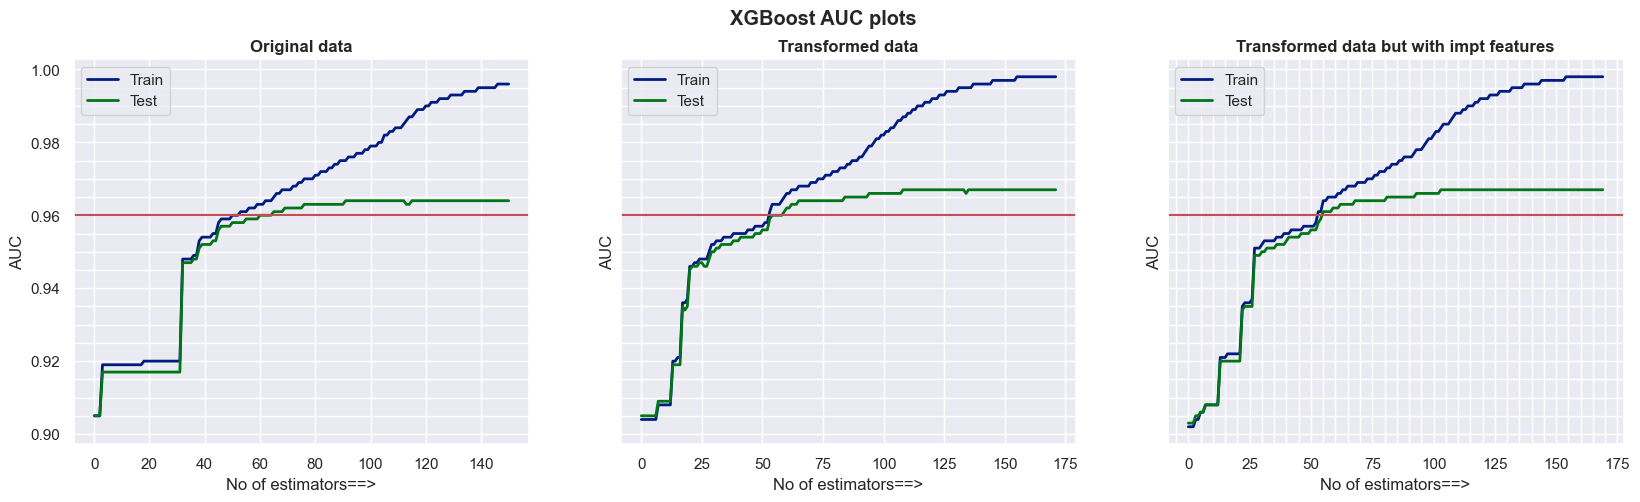

In [178]:
# 12.0 Learning curves of all the three models

plt.style.use('seaborn-v0_8-dark-palette')
# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,3, figsize = (20,5), sharey = True);
results = [model_orig.evals_result(),model_trans.evals_result(),model_trans_impt.evals_result() ]
title = ["Original data", 'Transformed data', 'Transformed data but with impt features']
fig.suptitle("XGBoost AUC plots", fontweight = "bold")
for i in range(3):
    epochs = len(results[i]['validation_0']['auc'])
    x_axis = range(0,epochs)
    ax[i].plot(x_axis, np.round(results[i]['validation_0']['auc'],3),linewidth=2, label='Train');
    ax[i].plot(x_axis, np.round(results[i]['validation_1']['auc'],3), linewidth=2, label='Test');
    ax[i].legend();
    ax[i].grid(visible = True, which = 'both');
    plt.minorticks_on();
    ax[i].set_ylabel('AUC');
    ax[i].set_xlabel("No of estimators==>")
    ax[i].set_title(title[i], fontsize = 12, fontweight = "bold");
    ax[i].axhline(y = 0.96, color = 'r', linestyle = '-')

plt.show();



## Preparing for PCA--imputing data
PCAs of transformed data. Purpose of PCA is two fold. One, to discover structure in data and second to balance data using techniques of imblearn package. Column 'ip' has a large number of levels. We treat 'ip' as a numeric feature for applying class-balancing techniques.   

In [303]:
# 13.0 Check if any nulls in data
#       If so, we would impute using SimpleImputer:

X_train_trans.isnull().sum().sum()  # 0
X_test_trans.isnull().sum().sum()   # 5313
X_train_trans_copy = X_train_trans.copy()
X_test_trans_copy  = X_test_trans.copy()
_=gc.collect()

0

5511

In [304]:
# 13.1 Impute as test data has null values:

start = time.time()
print("Imputing....")
si = SimpleImputer(strategy = 'median')
X_train_trans_copy[:] = si.fit_transform(X_train_trans_copy)
X_test_trans_copy[:] = si.transform(X_test_trans_copy)
end = time.time()
print("Done: ", (end-start)/60)  # 3 min
_ = gc.collect()

Imputing....
Done:  2.575364359219869


In [305]:
# 13.1.1 Check for nulls again:

X_train_trans_copy.isnull().sum().sum()  # 0
X_test_trans_copy.isnull().sum().sum()   # 0

0

0

### Save imputed data

In [136]:
# 13.2 Save pca_train and pca_test for later experiments:

X_train_trans_copy.to_pickle(Path(talkingdatadata) / "X_train_trans_copy.pkl")
X_test_trans_copy.to_pickle(Path(talkingdatadata) / "X_test_trans_copy.pkl")

# 13.2.0 Datashapes of imputed data:
X_train_trans_copy.shape  # (3747190, 137)
X_test_trans_copy.shape   # (1249064, 137)

(3747190, 137)

(1249064, 137)

### Read imputed data

In [306]:
# 13.2.1 Read back saved pca_train and pca_test data:

X_train_trans_copy = pd.read_pickle(Path(talkingdatadata) / "X_train_trans_copy.pkl")
X_test_trans_copy = pd.read_pickle(Path(talkingdatadata) / "X_test_trans_copy.pkl")

# 13.2.2 Check
X_train_trans_copy.shape  # (3747190, 137)
X_test_trans_copy.shape   # (1249064, 137)

(3747190, 137)

(1249064, 137)

In [291]:
#ipx = X_train_trans_copy.pop('ip')
#ipy = X_test_trans_copy.pop('ip')

### Perform 95% PCA 

In [307]:
# 13.3 PCA with transformed train data.
#      Note that n_components = 0.95
#      ip is included as a numeric feature

pca = PCA(n_components= 0.95,
          whiten= True, 
          random_state = rng
         )
ss = StandardScaler()
pca_train = pca.fit_transform(ss.fit_transform(X_train_trans_copy))
pca_test = pca.transform(ss.transform(X_test_trans_copy))

# 13.3.1 Check data shapes:
pca_train.shape  # (3747190, 26)
pca_test.shape   # (1249064, 26)

(3747190, 26)

(1249064, 26)

In [308]:
# 13.4 Assign column names and transform to DataFrame:

colnames = ["pc" + str(i) for i in range(pca_train.shape[1])]
pca_train = pd.DataFrame(pca_train, columns = colnames)
pca_test = pd.DataFrame(pca_test, columns = colnames)

# 13.4.1 Dataframe shapes:
pca_train.shape  #(3747190, 26)
pca_test.shape   # (1249064, 26)

(3747190, 26)

(1249064, 26)

In [ ]:
#ptr = pd.merge(ipx, pca_train, left_index = True, right_index = True)
#pte = pd.merge(ipy, pca_test, left_index = True, right_index = True)

### Plotting PCA

In [310]:
# 13.5 Take a stratified sample for plotting:
#      Just 50000 samples:

_, pca_tr, _,pca_y  = train_test_split(pca_train, y_train,
                                       test_size = 50000,
                                       stratify = y_train
                                      )

# 13.5.1 Our data for plotting:
pca_tr.shape  # 50000, 25)
pca_y.shape   # (50000, )

(50000, 26)

(50000,)

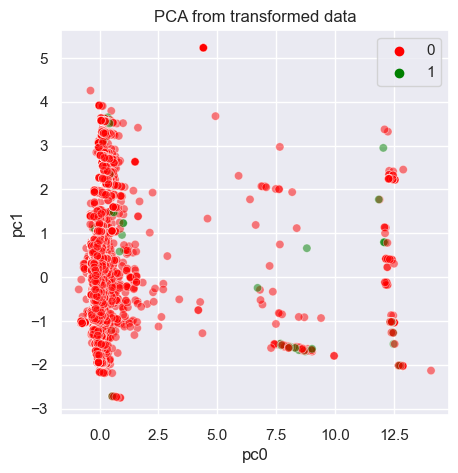

In [311]:
# 13.6 2D PCA plot from first two principal components:

fig = plt.figure(figsize = (5,5));
fig.add_subplot(1,1,1);
sns.set_theme() ; # Set default theme
plt.style.use('seaborn-v0_8-dark-palette')
sns.scatterplot(data = pca_tr,
                x=  'pc0',
                y = 'pc1',
                hue = pca_y.values,
                palette = ["red", "green"], alpha = 0.5
                ).set(title='PCA from transformed data') ;

### Save PCA data

In [313]:
# 14.0 Save pca_train and pca_test for later experiments:

pca_train.to_pickle(talkingdatadata / "pca_train95.pkl")
pca_test.to_pickle(talkingdatadata / "pca_test95.pkl")

### Read back PCA data

In [314]:
# 14.1 Read back saved data:

pca_train95 = pd.read_pickle(talkingdatadata / "pca_train95.pkl")
pca_test95 =  pd.read_pickle(talkingdatadata / "pca_test95.pkl")

# 14.1.1 Check
pca_train95.head(3)
pca_test95.head(3)

,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc16,pc17,pc18,pc19,pc20,pc21,pc22,pc23,pc24,pc25
0,-0.225065,0.858325,-0.004079,-0.332021,-0.173232,0.497744,1.025693,-1.473010,0.311314,1.106852,...,-0.403894,2.000244,-0.695795,-0.666294,0.977003,-0.451581,-1.958673,-0.367184,1.670911,-0.739815
1,-0.176948,0.078731,1.671639,-0.361550,-0.732443,1.201530,-0.230295,0.715127,-1.640440,0.222831,...,-2.960338,-1.640163,-1.242306,1.103948,-1.020902,3.047049,-2.193540,1.590481,0.588720,6.489935
2,-0.212824,-0.408851,0.191115,-0.063815,0.337900,0.369136,-1.002821,-0.207094,-0.477387,0.885387,...,-0.493695,0.968940,0.898825,-0.003742,1.250908,0.211316,-0.523079,-0.490511,2.158189,0.137476


,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc16,pc17,pc18,pc19,pc20,pc21,pc22,pc23,pc24,pc25
0,-0.109443,-0.401427,-0.935565,2.669815,-2.239555,-1.882825,-0.404365,-2.277835,-0.931411,0.388211,...,0.058212,0.818344,-0.518881,1.517607,-0.773102,-0.979468,0.309694,0.057472,2.154926,0.114434
1,-0.174146,0.155016,0.042191,-0.167398,0.213517,0.154390,-0.587997,-0.841854,-0.202014,-0.523275,...,0.079916,0.197830,-0.310761,-0.586854,0.021970,0.570062,-0.407362,-0.228724,-1.410661,1.037757
2,0.007833,-0.921785,-0.011014,-0.019185,0.477276,-0.469765,-0.479622,0.613446,0.265614,-1.420023,...,0.665577,-1.414605,0.104241,-2.303577,0.215926,1.412081,-1.456779,0.110193,0.713089,-0.106997


### xgboost modeling with all the PCA components

In [315]:
# 15.0 Prepare xgboost model--PCA data

model_pca = xgb.XGBClassifier( n_estimators= 200,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 15,
                               subsample = 0.8,
                               #class_weight = class_weights,   
                               random_state = rng,
                           )


tr_X =   pca_train95  # ptr
test_X = pca_test95   # pte
ytrain = y_train     
ytest = y_test       


model_pca.fit(tr_X, ytrain.values,
                     early_stopping_rounds = 50,   
                     eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
                     eval_metric = ['auc']    # binary classification problem
                    )

[12:42:13] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[12:42:21] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1668 extra nodes, 0 pruned nodes, max_depth=15
[0]	validation_0-auc:0.89281	validation_1-auc:0.88891
[12:42:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1244 extra nodes, 0 pruned nodes, max_depth=15
[1]	validation_0-auc:0.89324	validation_1-auc:0.88972
[12:42:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1428 extra nodes, 0 pruned nodes, max_depth=15
[2]	validation_0-auc:0.89424	validation_1-auc:0.89610
[12:42:42] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1372 extra nodes, 0 pruned nodes, max_depth=15
[3]	validation_0-auc:0.89587	vali

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [316]:
# 15.0.1 Save model:
_ = gc.collect()
utils.savePythonObject(model_pca, "model_pca.pkl", talkingdataestimators)

Object saved to: D:\talkingdata\allmodels\estimators\model_pca.pkl


In [318]:
# 15.0.2 Restore model:

model_pca = utils.restorePythonObject("model_pca.pkl", talkingdataestimators)

In [317]:
# 15.1 Best Scores:

model_pca.best_score     # 0.96324915726
model_pca.best_iteration # 118

0.9632491572693522

118

### Classification report
xgboost modeling with PCA data

In [319]:
# 15.2 Classification report of model with PCA data:

pred = model_pca.predict(test_X)
cr_pca = classification_report(ytest, pred)
print(cr_pca)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1245963
           1       0.73      0.34      0.46      3101

    accuracy                           1.00   1249064
   macro avg       0.87      0.67      0.73   1249064
weighted avg       1.00      1.00      1.00   1249064



### Learning curve
xgboost modeling with PCA data

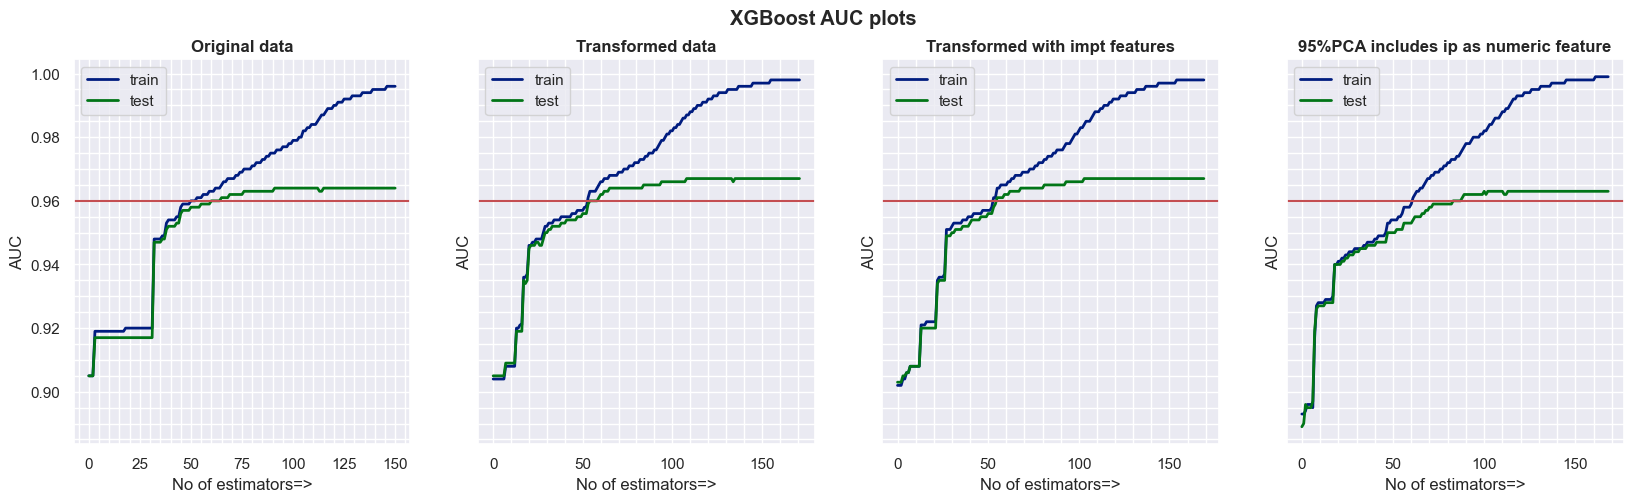

In [322]:
# 15.3
plt.style.use('seaborn-v0_8-dark-palette')
# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,4, figsize = (20,5), sharey = True);
results = [model_orig.evals_result(),model_trans.evals_result(), model_trans_impt.evals_result(), model_pca.evals_result() ]
title = ["Original data", 'Transformed data','Transformed with impt features', '95%PCA, includes ip as numeric feature']
fig.suptitle("XGBoost AUC plots", fontweight = "bold")
for i in range(4):
    epochs = len(results[i]['validation_0']['auc'])
    x_axis = range(0,epochs)
    ax[i].plot(x_axis, np.round(results[i]['validation_0']['auc'],3),linewidth=2, label='train');
    ax[i].plot(x_axis, np.round(results[i]['validation_1']['auc'],3), linewidth=2, label='test');
    ax[i].legend();
    ax[i].grid(visible = True, which = 'both');
    ax[i].minorticks_on();
    ax[i].set_ylabel('AUC');
    ax[i].set_xlabel("No of estimators=>")
    ax[i].set_title(title[i], fontsize = 12, fontweight = "bold");
    ax[i].axhline(y = 0.96, color = 'r', linestyle = '-')

plt.show();

## Balanacing PCA train data with `imblearn` library
We use imblearn library
>Balance with [`EditedNearestNeighbours`](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.EditedNearestNeighbours.html)<br>
>Balance with [`SMOTEENN`](https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTEENN.html)<br>
>Balance with [`OneSidedSelection`](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.OneSidedSelection.html)<br>

In [338]:
# 16.0 Call imblearn library:

from imblearn.under_sampling import EditedNearestNeighbours,OneSidedSelection   # This works with full PCA
from imblearn.combine import SMOTEENN

## Using `EditedNearestNeighbours`

In [365]:
# 16.1 Undersample PCA train data:

start = time.time()
undersample = EditedNearestNeighbours()   
X_res, y_res = undersample.fit_resample(pca_train, y_train)
end = time.time()
print((end-start)/60)  # 118 min

# 16.1.1 Data shape
X_res.shape  #  (3733315, 26)
y_res.shape  #  (3733315,)

117.22239671548208


(3733315, 26)

(3733315,)

### Plot of Ist two components of cleanedup data

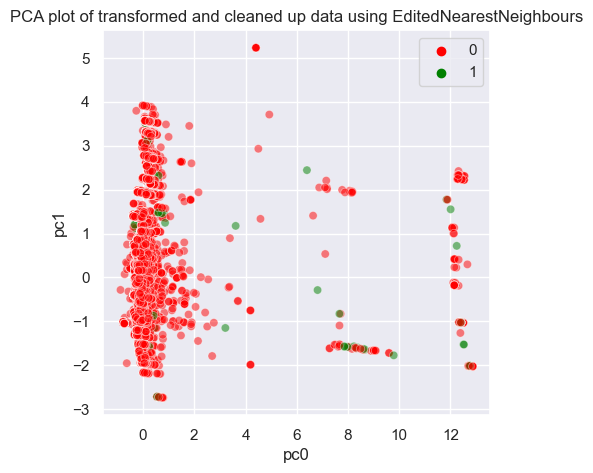

In [157]:
# 17.0 2D PCA plot from first two principal components
#      of undersampled data:
#      First take a stratified sample for plotting
#      And then plot:

_, pca_tr, _,pca_y  = train_test_split(X_res, 
                                       y_res,
                                       test_size = 50000,
                                       stratify = y_res
                                      )

# 17.0.1
pca_tr.shape  # (50000, 26)
pca_y.shape   # (50000,)

# 17.0.2

fig = plt.figure(figsize = (5,5));
fig.add_subplot(1,1,1);
sns.set_theme() ; 
sns.scatterplot(data = pca_tr,  # Sample of 50000
                x=  'pc0',
                y = 'pc1',
                hue = pca_y.values,
                palette = ["red", "green"],alpha = 0.5
                ).set(title='PCA plot of transformed and cleaned up data using EditedNearestNeighbours') ;

### xgboost modeling with undersampled data

In [366]:
# 17.1 xgboost Modeling with undersampled data

model_en = xgb.XGBClassifier( n_estimators= 250,
                               verbosity = 3,
                               eta = 0.06,     
                               max_depth = 15,
                               subsample = 0.9,          
                               random_state = rng,
                           )


tr_X =   X_res 
test_X = pca_test
ytrain = y_res 
ytest =  y_test


model_en.fit(tr_X, ytrain.values,                  
          early_stopping_rounds = 100,   
          eval_set=[(tr_X, ytrain.values), (test_X, ytest.values)],
          eval_metric = ['aucpr', 'auc']    
          )



[11:42:43] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[11:42:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1710 extra nodes, 0 pruned nodes, max_depth=15
[0]	validation_0-aucpr:0.69709	validation_0-auc:0.89515	validation_1-aucpr:0.46375	validation_1-auc:0.89698
[11:42:59] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1412 extra nodes, 0 pruned nodes, max_depth=15
[1]	validation_0-aucpr:0.71389	validation_0-auc:0.89555	validation_1-aucpr:0.47255	validation_1-auc:0.89728
[11:43:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1512 extra nodes, 0 pruned nodes, max_depth=15
[2]	validation_0-aucpr:0.72153	validation_0-auc:0.89561	validation_1-aucpr:0.47802	validation_1-auc:0.89733
[11:43:13] INFO: C:\Users\dev-admin\croot2

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [369]:
# 17.1.1 Save the model

utils.savePythonObject(model_en, "model_en.pkl", talkingdataestimators)

Object saved to: D:\talkingdata\allmodels\estimators\model_en.pkl


In [24]:
# 17.1.2 Read the model:

model_en= utils.restorePythonObject("model_en.pkl", talkingdataestimators)


In [371]:
# 17.2 Scores:

model_en.best_score     # 0.9642228587
model_en.best_iteration # 157

0.964384101757338

152

### Classification report
After balancing data with `EditedNearestNeighbours` class

In [372]:
# 17.3 Classification report xgboost model with undersampled PCA data:

pred = model_en.predict(pca_test)
cr_en = classification_report(y_test, pred)
print(cr_en)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1245963
           1       0.53      0.51      0.52      3101

    accuracy                           1.00   1249064
   macro avg       0.77      0.75      0.76   1249064
weighted avg       1.00      1.00      1.00   1249064



## Learning curves

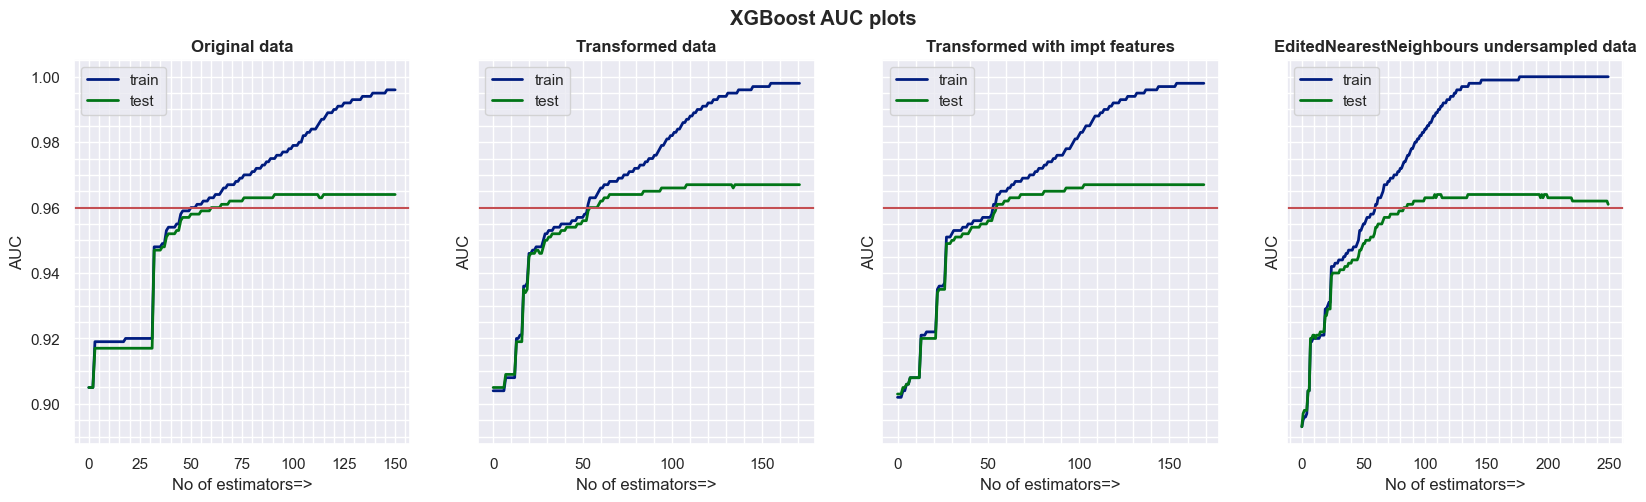

In [327]:
# 17.4:

plt.style.use('seaborn-v0_8-dark-palette')
# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,4, figsize = (20,5), sharey = True);
results = [model_orig.evals_result(),model_trans.evals_result(), model_trans_impt.evals_result(), model_en.evals_result() ]
title = ["Original data", 'Transformed data','Transformed with impt features', 'EditedNearestNeighbours undersampled data']
fig.suptitle("XGBoost AUC plots", fontweight = "bold")
for i in range(4):
    epochs = len(results[i]['validation_0']['auc'])
    x_axis = range(0,epochs)
    ax[i].plot(x_axis, np.round(results[i]['validation_0']['auc'],3),linewidth=2, label='train');
    ax[i].plot(x_axis, np.round(results[i]['validation_1']['auc'],3), linewidth=2, label='test');
    ax[i].legend();
    ax[i].grid(visible = True, which = 'both');
    ax[i].minorticks_on();
    ax[i].set_ylabel('AUC');
    ax[i].set_xlabel("No of estimators=>")
    ax[i].set_title(title[i], fontsize = 12, fontweight = "bold");
    ax[i].axhline(y = 0.96, color = 'r', linestyle = '-')

plt.show();


## Using `SMOTEENN`
For balancing PCA data. But it also generates a lot of noisy samples.

In [180]:
# 18.0 Instantiate SMOTEEN and use it on pca_train

start= time.time()
sm = SMOTEENN(random_state=rng)
X_res, y_res = sm.fit_resample(pca_train, y_train)
end = time.time()
print((end-start)/60)  # 469 min


# 18.0.1 Data shape after SMOTEENN

X_res.shape  # (7444224, 26)
y_res.shape  # (7444224,)

469.22368932962416


(7444224, 26)

(7444224,)

In [181]:
# 18.0.2

y_res.value_counts()
y_res.value_counts(normalize = True)  # 50%:50%

1    3737820
0    3706404
Name: isattributed, dtype: int64

1    0.50211
0    0.49789
Name: isattributed, dtype: float64

### Plot of Ist two components of cleanedup data

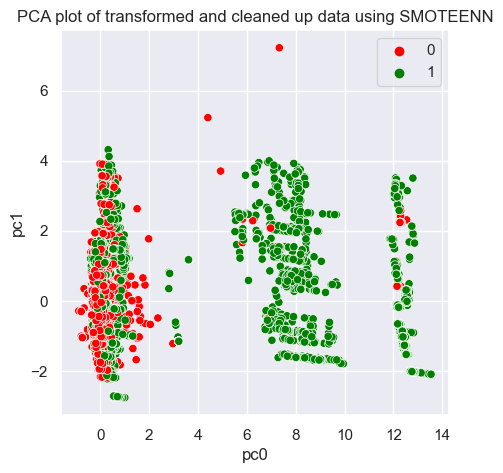

In [182]:
# 18.0.3 2D PCA plot from first two principal components:
#         First take a stratified sample for plotting
#         And then plot:

_, pca_tr, _,pca_y  = train_test_split(X_res, y_res, test_size = 50000, stratify = y_res)
pca_tr.shape  # (50000, 26)
pca_y.shape   # (5000,)

fig = plt.figure(figsize = (5,5));
fig.add_subplot(1,1,1);
sns.set_theme() ; 
sns.scatterplot(data = pca_tr,  # Sample of 5000
                x=  'pc0',
                y = 'pc1',
                hue = pca_y.values,
                palette = ["red", "green"]
                ).set(title='PCA plot of transformed and cleaned up data using SMOTEENN') ;

### xgboost modeling with balanced data (`SMOTEENN`)

In [184]:
# 19.0 Modeling with smoteenn data (without ip and rem features)

model_sm = xgb.XGBClassifier( n_estimators= 200,
                               verbosity = 3,
                               eta = 0.06,     
                               max_depth = 12,
                               subsample = 0.8,          
                               random_state = rng,
                           )


tr_X =   X_res 
test_X = pca_test
ytrain = y_res 
ytest =  y_test


model_sm.fit(tr_X, ytrain.values,                  
                early_stopping_rounds = 50,   
                eval_set=[(tr_X, ytrain.values), (test_X, ytest.values)],
                eval_metric = ['auc']    
                )



[18:03:24] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:149: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[18:03:24] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 1
[18:03:24] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:122: Using updaters: grow_histmaker
[18:03:24] ======== Monitor (0): TreePruner ========
[18:03:24] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\data\simple_dmatrix.cc:102: Generating new Gradient Index.
[18:03:28] ======== Monitor (0): SortedSketchContainer ========
[18:03:28] AllReduce: 8.5e-05s, 1 calls @ 85us

[18:03:28] MakeCuts: 0.000142s, 1 calls @ 142us

[18:03:28] PushColPage: 0.850384s, 1 calls @ 850384us

[0]	validation_0-auc:0.97560	validation_1-auc:0.93011
[18:03:30] INFO: C:\User

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=12,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [186]:
utils.savePythonObject(model_sm, "model_sm.pkl", talkingdataestimators)

Object saved to: D:\talkingdata\allmodels\estimators\model_sm.pkl


In [328]:
model_sm = utils.restorePythonObject("model_sm.pkl", talkingdataestimators)

In [329]:
# 19.1 Best score
model_sm.best_score   #0.955446494261
model_sm.best_iteration  # 31

0.9554464942610063

31

### Classification report
After balancing with `SMOTEENN` class 

In [331]:
# 19.2 
pred = model_sm.predict(pca_test)
cr_smee = classification_report(y_test, pred)
print(cr_smee)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99   1245963
           1       0.08      0.83      0.14      3101

    accuracy                           0.98   1249064
   macro avg       0.54      0.90      0.56   1249064
weighted avg       1.00      0.98      0.99   1249064



### Learning plots
xgboost modeling with the two class balancing techniques

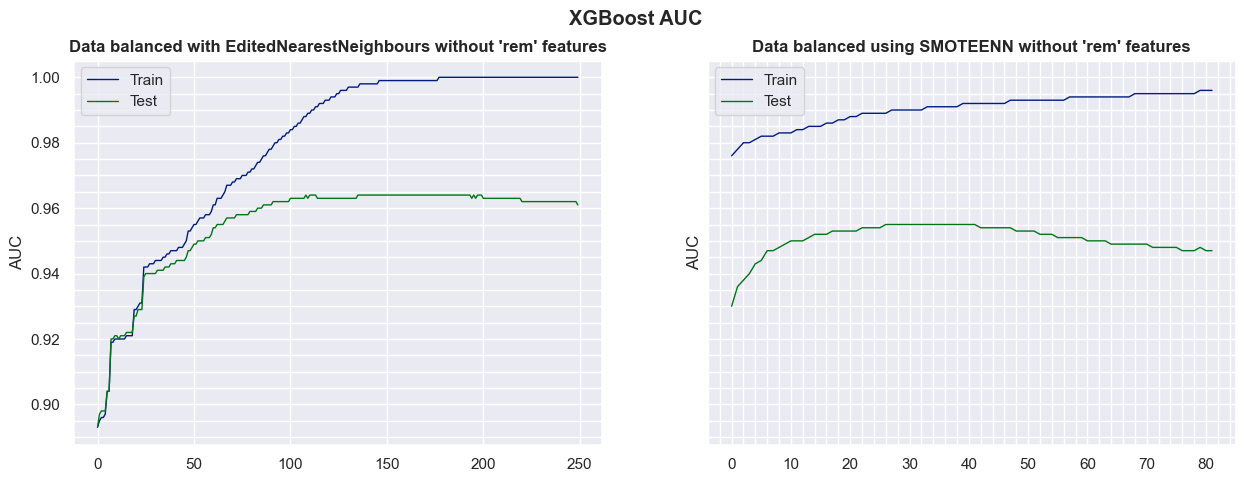

In [332]:
# 19.3 Learning curves: xgboost modeling (SMOTEENN)

plt.style.use('seaborn-v0_8-dark-palette')
# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,2, figsize = (15,5), sharey = True);
results = [model_en.evals_result(),model_sm.evals_result()]
title = ["Data balanced with EditedNearestNeighbours without 'rem' features", "Data balanced using SMOTEENN without 'rem' features"]
fig.suptitle("XGBoost AUC", fontweight = "bold")
for i in range(2):
    epochs = len(results[i]['validation_0']['auc'])
    x_axis = range(0,epochs)
    ax[i].plot(x_axis, np.round(results[i]['validation_0']['auc'],3),linewidth=1, label='Train');
    ax[i].plot(x_axis, np.round(results[i]['validation_1']['auc'],3), linewidth=1, label='Test');
    ax[i].legend();
    ax[i].grid(visible = True, which = 'both');
    plt.minorticks_on();
    ax[i].set_ylabel('AUC');
    ax[i].set_title(title[i], fontsize = 12, fontweight = "bold");

plt.show();

In [25]:
# 19.5 And read back saved class object:
model_pca = utils.restorePythonObject("model_pca.pkl", talkingdataestimators)
model_en= utils.restorePythonObject("model_en.pkl", talkingdataestimators)
model_sm= utils.restorePythonObject("model_sm.pkl", talkingdataestimators)

## Distribution of transformed features:

eigenvector          0.272727
degree               0.181818
pagerank             0.181818
clusteringcoeff      0.181818
betweenness          0.181818
avgembeddedness      0.000000
leidencomsdensity    0.000000
dtype: float64

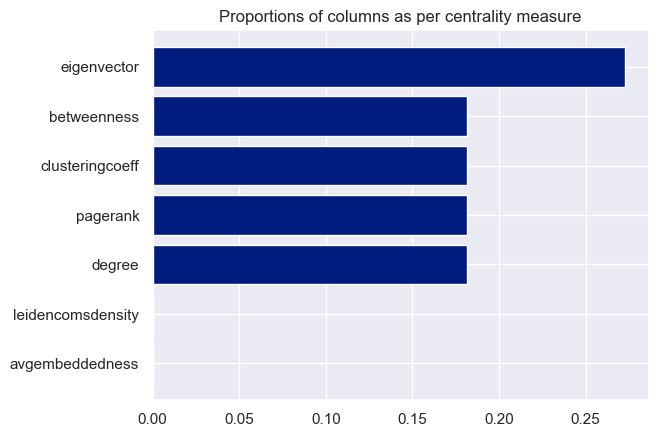

In [196]:
# 20.0 Distribution of columns related to different centrality measures

### Proportion of columns by centrality measure:

# 20.0 Our list of columns

colList = X_train_trans.columns

# 20.0.1 Count of columns by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(colList, normalize = True)
f
utils.plotSeries(f, "Proportions of columns as per centrality measure")


### Proportions of columns by centrality whose impt is > 0

In [197]:
# 20.1 Extract column importance while building model_trans:

fe_1, fe_0,_ = utils.xgImptFeatures(model_trans, colList)
f"Columns whose impt is >0: {len(fe_1)}"
print("\n")
f"Columns whose impt is 0: {len(fe_0)}"

Order of feature importance is by 'gain'


'Columns whose impt is >0: 135'

'Columns whose impt is 0: 2'

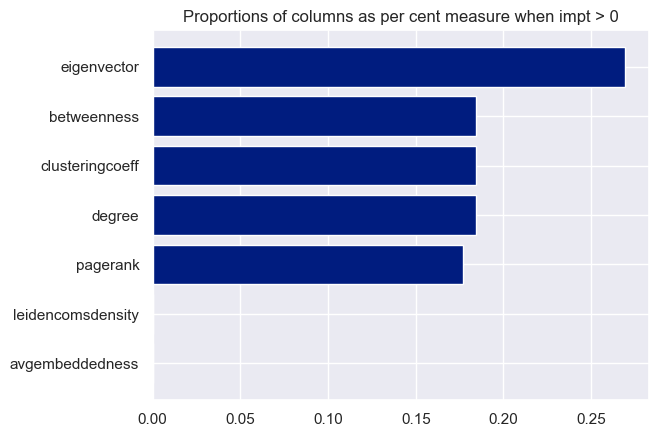

In [198]:
# 20.2 Count of columns whose xgboost impt > 0 by centrality measure and its plot:

f = utils.featureImptByCentFeatCounts(fe_1, normalize = True)
utils.plotSeries(f, "Proportions of columns as per cent measure when impt > 0")



### Proportions of columns by summed-up importance score of each centrality measure

Order of feature importance is by 'gain'


pr_channel_ck_device           0.282810
bet_channel_ck_device          0.223983
clu_app_ck_device_p_channel    0.086750
bet_channel_ck_app_p_os        0.026434
pr_channel_ck_os               0.024596
Name: imp, dtype: float32

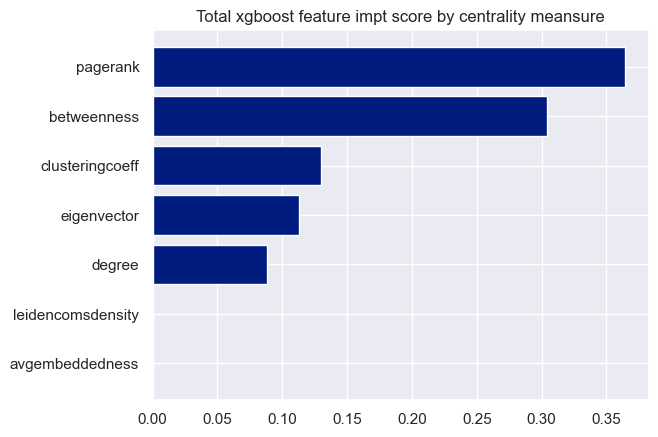

In [199]:
# 20.3 Extract xgboost feature importance:

fe_1, _, fe = utils.xgImptFeatures(model_trans, colList)

# 20.4 Column-wise importance score (whose impt > 0)
#      score is a Pandas Series
score = fe['imp'][fe_1]

# 13.2 Score of top-five columns:
score[:5]

# 20.5 Extract and plot total xgboost impt scores by centrality measure:

g = utils.featureImptByScore(score, fe_1, True)
utils.plotSeries(g, "Total xgboost feature impt score by centrality meansure")

## Analysing Graphs


In [202]:
# 21.0 Path where .gml files are placed:

filelist = sorted(list(talkingdatagraphs.iterdir()))
filelist[5:10]   


[WindowsPath('D:/talkingdata/allmodels/models/app_bigraph_device_p_channel.gml'),
 WindowsPath('D:/talkingdata/allmodels/models/app_bigraph_device_p_os.gml'),
 WindowsPath('D:/talkingdata/allmodels/models/app_bigraph_os.gml'),
 WindowsPath('D:/talkingdata/allmodels/models/app_bigraph_os_p_channel.gml'),
 WindowsPath('D:/talkingdata/allmodels/models/app_projected_app_p_channel.gml')]

### Readback data files

In [203]:
# 21.1
talkingdata = Path("D:\\talkingdata\\allmodels")

talkingdatagraphs = talkingdata / "models"
talkingdatadata = talkingdata / "datafiles"
talkingdataestimators = talkingdata / "estimators"
talkingdataunitvecs = talkingdata  / "unitvec"

In [205]:
# 21.2 A quick readback all saved files

train_trans = pd.read_pickle(Path(talkingdatadata) / "train_trans.pkl")
test_trans = pd.read_pickle(Path(talkingdatadata) / "test_trans.pkl")
X_train = pd.read_pickle(Path(talkingdatadata) / "X_train.pkl")
X_test = pd.read_pickle(Path(talkingdatadata) / "X_test.pkl")
y_train = pd.read_pickle(Path(talkingdatadata) / "y_train.pkl")
y_test = pd.read_pickle(Path(talkingdatadata) / "y_test.pkl")


# 21.2.1 Reindex X_train/X_test

X_train = X_train.reset_index( drop = True )
X_test = X_test.reset_index(drop = True)

# 21.2.2 Check
train_trans.head(2)
test_trans.head(2)
X_train.head(2)
X_test.head(2)

# 21.2.3
train_trans.shape   # (3000806, 136)/(3002043, 136)/(3001476, 136)/(3747190, 136)
y_train.shape       # (3000806, )/(3002043, )/(3001476, )
test_trans.shape    # (1000269, 136)/(1000682, 136)/(1000493, 136)/(1249064, 136)
y_test.shape        # (1000269, )/(1000682, )/(1000493, )


# 21.2.4 Our cat cols
cat_cols = ['app', 'device', 'os', 'channel']  # 4cols

# 21.2.5 Remaining cols not treated as cat cols:
rem_cols = {'ip', 'minute', 'day', 'hour', 'second'} # 5 cols


# 21.3 Concat rem_cols with transformed data:

# 21.4 Columns after transformeation to be considered. Ignore initial cat_cols
cols = train_trans.columns[len(cat_cols):]

# 21.5 Now horizontally concatenate:
X_train_trans = pd.concat([X_train[rem_cols], train_trans[cols] ],  axis = 1)
X_test_trans = pd.concat([X_test[rem_cols], test_trans[cols] ], axis = 1)
                           
# 21.6 Check
X_train_trans.shape  # (3000806, 137)/(3002043, 137)/(2998791, 136)/(3747190, 137)
X_test_trans.shape   # (3000806, )/(3002043, )/(2998791, )/(1249064, 137)

,app,device,os,channel,deg_app_ck_device,eig_app_ck_device,pr_app_ck_device,clu_app_ck_device,bet_app_ck_device,deg_app_ck_os,...,deg_channel_ck_device_p_os,eig_channel_ck_device_p_os,pr_channel_ck_device_p_os,clu_channel_ck_device_p_os,bet_channel_ck_device_p_os,deg_channel_ck_app_p_os,eig_channel_ck_app_p_os,pr_channel_ck_app_p_os,clu_channel_ck_app_p_os,bet_channel_ck_app_p_os
0,13,1,13,477,0.809917,0.076224,0.003801,0.697174,0.002960,0.834711,...,0.971591,0.077525,0.005920,0.970210,0.000757,0.164773,3.902822e-02,0.004952,0.633005,0.004242
1,22,1,19,116,0.779614,0.074330,0.003666,0.717791,0.002223,0.834711,...,0.960227,0.077257,0.005838,0.986616,0.000093,0.005682,2.230271e-17,0.004544,0.000000,0.000000


,app,device,os,channel,deg_app_ck_device,eig_app_ck_device,pr_app_ck_device,clu_app_ck_device,bet_app_ck_device,deg_app_ck_os,...,deg_channel_ck_device_p_os,eig_channel_ck_device_p_os,pr_channel_ck_device_p_os,clu_channel_ck_device_p_os,bet_channel_ck_device_p_os,deg_channel_ck_app_p_os,eig_channel_ck_app_p_os,pr_channel_ck_app_p_os,clu_channel_ck_app_p_os,bet_channel_ck_app_p_os
0,3,2,19,280,0.809917,0.076224,0.003801,0.697174,0.002960,0.837466,...,0.977273,0.077637,0.005963,0.961648,0.000865,0.397727,0.121408,0.009006,0.604141,0.008494
1,15,1,19,245,0.768595,0.073619,0.003617,0.724014,0.002355,0.834711,...,0.965909,0.077355,0.005884,0.977445,0.000694,0.289773,0.074779,0.006935,0.657255,0.003071


,ip,app,device,os,channel,day,hour,minute,second
0,128686,13,1,13,477,7,4,8,30
1,55146,22,1,19,116,9,12,30,0


,ip,app,device,os,channel,day,hour,minute,second
0,44961,3,2,19,280,7,1,42,4
1,62900,15,1,19,245,8,20,18,33


(3747190, 136)

(3747190,)

(1249064, 136)

(1249064,)

(3747190, 137)

(1249064, 137)

In [206]:
# 22.0 Get sample list of projected and bigraph files:

projected = [str(i).split("\\")[-1] for i in filelist if 'app_projected' in str(i)]
bigraphs = [str(i).split("\\")[-1] for i in filelist if 'app_bigraph' in str(i)]
bigraphs = sorted(bigraphs, key=len)
bigraphs[:8]   # bigraph files
print("\n\n====\n")
projected = sorted(projected, key=len)
projected[:8]    # projected graph files

['app_bigraph_os.gml',
 'app_bigraph_device.gml',
 'app_bigraph_channel.gml',
 'app_bigraph_app_p_os.gml',
 'app_bigraph_device_p_os.gml',
 'app_bigraph_app_p_device.gml',
 'app_bigraph_os_p_channel.gml',
 'app_bigraph_app_p_channel.gml']



====



['app_projected_os.gml',
 'app_projected_device.gml',
 'app_projected_channel.gml',
 'app_projected_app_p_os.gml',
 'app_projected_device_p_os.gml',
 'app_projected_app_p_device.gml',
 'app_projected_os_p_channel.gml',
 'app_projected_app_p_channel.gml']

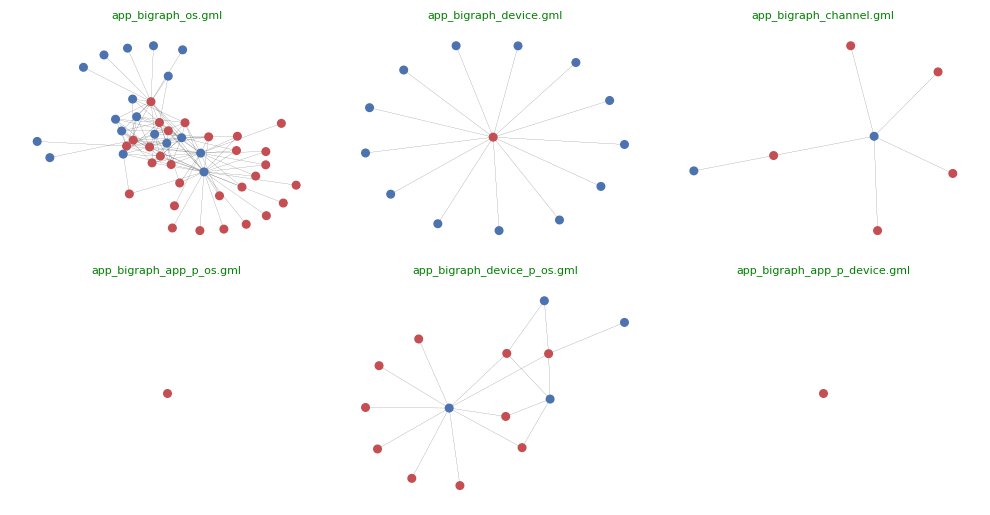

In [209]:
# 22.1 Plot of sample bigraphs:
plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(10,18));
for bi in bigraphs[:6]:
    ax = fig.add_subplot(7,3,pos);
    pos = pos + 1
    # Only show connedted nodes
    _= utils.plotBipartiteGraph( bi,
                                 talkingdatagraphs,
                                 ax = ax,
                                 title = bi,
                                 connected=True,  # Show only connected nodes
                                 takeGraphSample=True # Do not show full graph but a sample of it
                                 )
    plt.tight_layout();

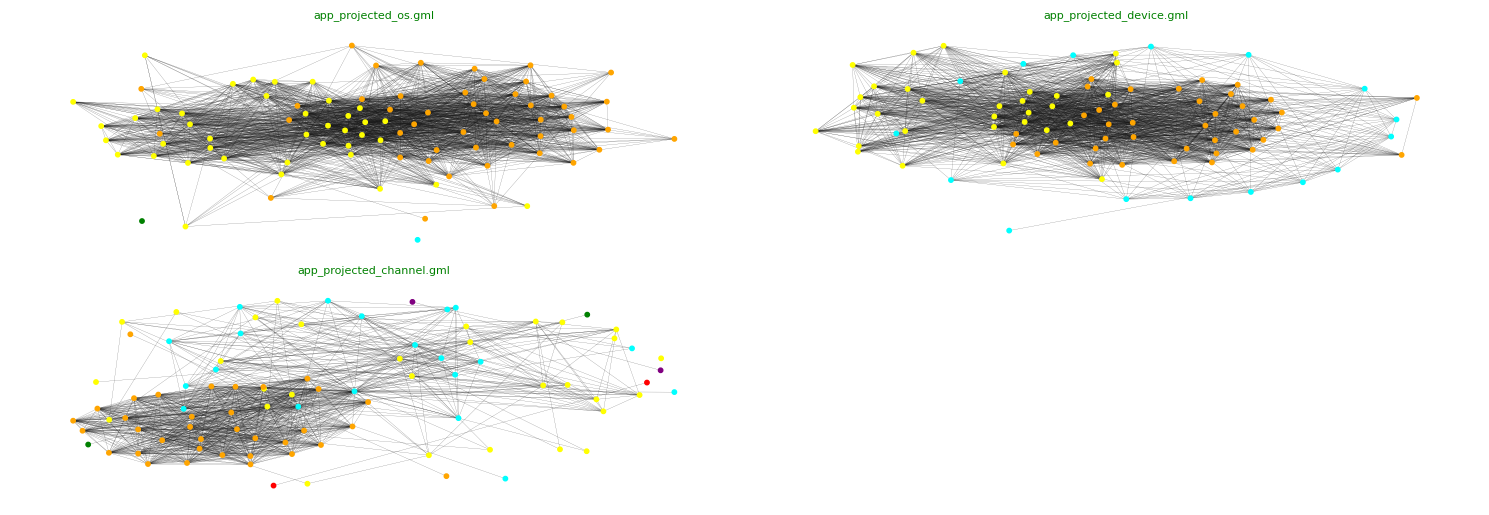

In [210]:
# 22.2 Plot of sample projected graph files
#      And community visualization within them
#      Modularity class is used to distinguish
#      communities:

plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(15,18));
for prj in projected[:3]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    # Only show connected nodes
    _=utils.communityVisualization(prj,
                                   talkingdatagraphs,
                                   ax = ax,
                                   k = 1.5,   # For spring_layout, to avoid crowding of nodes
                                   withLabels = False,
                                   node_size = 10,
                                   title = prj,
                                   takeGraphSample = True # Do not show full graph but a sample of it
                                   );
    plt.tight_layout();

In [212]:
# 23.0 Transform each column bin as per the community
#       to which it belongs:

# 23.1 Our transformed discrete cols are:
columnNames = cat_cols

# 23.2 Communities will be created as per this algo:
algolist = [nx.community.greedy_modularity_communities]

# 23.3 Graph files are within:
#graphFolder= Path("D:\\talkingdata\\allmodels\\models\\")

# 23.4 Perform transformation of both train_binned and test_binend:
# 23.4.1 List of transformed datframes as per difft algo used
fg_tr = []
fg_te = []
map_tr = []
map_te = []

# 23.4.2 PErform transformation to community structure
#  Takes lots of time...

for algo in algolist:
  print("\n..Transforming train data....")
  print("==========================\n")
  map1,df_tr = utils.transformBinnedDF2Communities(columnNames,talkingdatagraphs,X_train[cat_cols], algo = algo)
  print("\n==========================")
  print("..Transforming test data....")
  print("==========================\n")
  map2,df_te = utils.transformBinnedDF2Communities(columnNames,talkingdatagraphs,X_test[cat_cols], algo = algo)
  fg_tr.append(df_tr)
  fg_te.append(df_te)
  map_tr.append(map1)
  map_te.append(map2)


..Transforming train data....

Reading file:  app_projected_device.gml
Reading file:  app_projected_os.gml
Reading file:  app_projected_channel.gml
Reading file:  device_projected_app.gml
Reading file:  device_projected_os.gml
Reading file:  device_projected_channel.gml
Reading file:  os_projected_app.gml
Reading file:  os_projected_device.gml
Reading file:  os_projected_channel.gml
Reading file:  channel_projected_app.gml
Reading file:  channel_projected_device.gml
Reading file:  channel_projected_os.gml

..Transforming test data....

Reading file:  app_projected_device.gml
Reading file:  app_projected_os.gml
Reading file:  app_projected_channel.gml
Reading file:  device_projected_app.gml
Reading file:  device_projected_os.gml
Reading file:  device_projected_channel.gml
Reading file:  os_projected_app.gml
Reading file:  os_projected_device.gml
Reading file:  os_projected_channel.gml
Reading file:  channel_projected_app.gml
Reading file:  channel_projected_device.gml
Reading file:  ch

In [79]:
# 24.0 Observe few rows of data transformed community wise:
fg_tr[0].shape   # (3000806, 12)/(3002043, 12)/(3001476, 12)/(2998791, 12)/(2998791, 12)
print("\n--\n")
fg_te[0].shape   # (1000269, 12)/(1000682, 12)/(1000493, 12)/(999597, 12)/(999597, 12)
print("\n--\n")
fg_tr[0].head(2)
fg_te[0].head(2)

(2998791, 12)


--



(999597, 12)


--



,app_projected_device.gml,app_projected_os.gml,app_projected_channel.gml,device_projected_app.gml,device_projected_os.gml,device_projected_channel.gml,os_projected_app.gml,os_projected_device.gml,os_projected_channel.gml,channel_projected_app.gml,channel_projected_device.gml,channel_projected_os.gml
0,0,1,0,2,0,0,1,0,1,1,1,2
1,0,1,1,2,0,0,1,0,1,1,1,1


,app_projected_device.gml,app_projected_os.gml,app_projected_channel.gml,device_projected_app.gml,device_projected_os.gml,device_projected_channel.gml,os_projected_app.gml,os_projected_device.gml,os_projected_channel.gml,channel_projected_app.gml,channel_projected_device.gml,channel_projected_os.gml
0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0
1,0.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,2.0,1.0,1.0


In [213]:
# 24.1 Remove constant columns, if any, from train data:
fg_tr[0] = utils.remConstColumns(fg_tr[0])

# 24.1.1 Keep same columns as above in test data:
fg_te[0] = fg_te[0][fg_tr[0].columns]

Datashape before processing: (3747190, 12)
Datashape after processing: (3747190, 12)


In [214]:
# 24.2 Save the list:

utils.savePythonObject(fg_tr, "fg_tr.pkl", talkingdatadata)
utils.savePythonObject(fg_te, "fg_te.pkl", talkingdatadata)

Object saved to: D:\talkingdata\allmodels\datafiles\fg_tr.pkl
Object saved to: D:\talkingdata\allmodels\datafiles\fg_te.pkl


In [215]:
# 24.3 Retrieve back:

tr_comm = utils.restorePythonObject( "fg_tr.pkl", talkingdatadata )
te_comm = utils.restorePythonObject( "fg_te.pkl", talkingdatadata )
tr_comm[0].shape  # (2249729, 12)/(3002043, 12)/(2998791, 12)/(3747190, 12)
te_comm[0].shape  # (749910, 12)/(1000682, 12)/(999597, 12)/(1249064, 12)

(3747190, 12)

(1249064, 12)

In [216]:
# 24.4 Check restoration:

tr_comm[0].head(2)
te_comm[0].head(2)

,app_projected_device.gml,app_projected_os.gml,app_projected_channel.gml,device_projected_app.gml,device_projected_os.gml,device_projected_channel.gml,os_projected_app.gml,os_projected_device.gml,os_projected_channel.gml,channel_projected_app.gml,channel_projected_device.gml,channel_projected_os.gml
0,0,0,0,2,1,1,1,0,1,2,0,0
1,0,0,0,2,1,1,1,0,1,0,0,0


,app_projected_device.gml,app_projected_os.gml,app_projected_channel.gml,device_projected_app.gml,device_projected_os.gml,device_projected_channel.gml,os_projected_app.gml,os_projected_device.gml,os_projected_channel.gml,channel_projected_app.gml,channel_projected_device.gml,channel_projected_os.gml
0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0,2,1,1
1,0.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0,1,0,0


In [217]:
# 24.5 Merge rem cols in it:

tr_comm[0] = pd.concat([X_train[rem_cols], tr_comm[0] ],  axis = 1)
te_comm[0] = pd.concat([X_test[rem_cols], te_comm[0] ], axis = 1)

# 24.6 Shapes?
tr_comm[0].shape  # (3002043, 17)/(3001476, 17)/(2998791, 17)/(3747190, 17)
te_comm[0].shape  # (1000682, 17)/(1000493, 17)/(999597, 17)/(1249064, 17)

(3747190, 17)

(1249064, 17)

## xgboost modeling with data transformed through community classes

In [218]:
# 25.0 Modeling with transformed train/test data with community indicators:


# As we repeat the process many times:
# Del the earlier result, if exists:

if 'model_trans_commu' in globals():
    del model_trans_commu

model_trans_commu = xgb.XGBClassifier(  n_estimators= 500,
                                        verbosity = 3,
                                        eta = 0.06,
                                        max_depth = 15,
                                        subsample = 0.8,
                                        random_state = rng,
                                      )


tr_X =   tr_comm[0]
test_X = te_comm[0]
ytr = y_train
yte = y_test


model_trans_commu.fit(tr_X, ytr.values,
                      early_stopping_rounds = 100,
                      eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
                      eval_metric = ['auc']
                      )



[18:34:59] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[18:35:01] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 978 extra nodes, 0 pruned nodes, max_depth=15
[0]	validation_0-auc:0.85978	validation_1-auc:0.85466
[18:35:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 738 extra nodes, 0 pruned nodes, max_depth=15
[1]	validation_0-auc:0.86015	validation_1-auc:0.85513
[18:35:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 952 extra nodes, 0 pruned nodes, max_depth=15
[2]	validation_0-auc:0.86045	validation_1-auc:0.85530
[18:35:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 788 extra nodes, 0 pruned nodes, max_depth=15
[3]	validation_0-auc:0.86103	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

### Learning curve

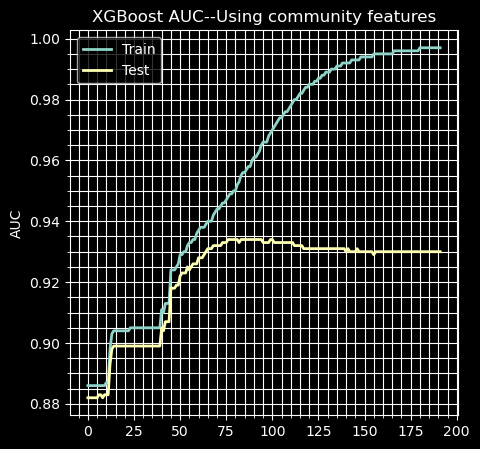

In [86]:
# 25.1 Modeling with Community data:

# Ref: https://stackoverflow.com/a/60366515
plt.style.use("dark_background")
plt.figure(figsize = (5,5));
results = model_trans_commu.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
plt.legend();
plt.grid(visible = True, which = 'both')
plt.minorticks_on()
plt.ylabel('AUC');
plt.title("XGBoost AUC--Using community features");


In [220]:
# 25.2 Save model object
utils.savePythonObject(model_trans_commu, "model_trans_commu.pkl", talkingdataestimators)

Object saved to: D:\talkingdata\allmodels\estimators\model_trans_commu.pkl


In [221]:
# 25.3 Recall model object
model_trans_commu = utils.restorePythonObject("model_trans_commu.pkl", talkingdataestimators)

#### Classification report

In [222]:
# 25.4 Classification reports:

pred_comm = model_trans_commu.predict(test_X)
print(f"Classification report from community data: \n {classification_report(ytest,pred_comm)}")





Classification report from community data: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1245963
           1       0.56      0.08      0.14      3101

    accuracy                           1.00   1249064
   macro avg       0.78      0.54      0.57   1249064
weighted avg       1.00      1.00      1.00   1249064



In [ ]:
"""
Classification report from community data: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    997845
           1       0.67      0.05      0.10      2424

    accuracy                           1.00   1000269
   macro avg       0.83      0.53      0.55   1000269
weighted avg       1.00      1.00      1.00   1000269


Classification report from community data: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    998259
           1       0.38      0.06      0.10      2423

    accuracy                           1.00   1000682
   macro avg       0.69      0.53      0.55   1000682
weighted avg       1.00      1.00      1.00   1000682

Classification report from community data: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    998061
           1       0.41      0.03      0.05      2432

    accuracy                           1.00   1000493
   macro avg       0.70      0.51      0.52   1000493
weighted avg       1.00      1.00      1.00   1000493

Classification report from community data: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    997124
           1       0.63      0.18      0.28      2473

    accuracy                           1.00    999597
   macro avg       0.81      0.59      0.64    999597
weighted avg       1.00      1.00      1.00    999597



"""

## Derive unit-vectors per level per cat column



In [333]:
# 26.0 Quick recap:

talkingdata = Path("D:\\talkingdata\\allmodels")

talkingdatagraphs = talkingdata / "models"
talkingdatadata = talkingdata / "datafiles"
talkingdataestimators = talkingdata / "estimators"
talkingdataunitvecs = talkingdata  / "unitvec"

In [334]:
# 26.1 A quick readback all saved files

train_trans = pd.read_pickle(talkingdatadata / "train_trans.pkl")
test_trans = pd.read_pickle(talkingdatadata / "test_trans.pkl")
X_train = pd.read_pickle(talkingdatadata / "X_train.pkl")
X_test = pd.read_pickle(talkingdatadata / "X_test.pkl")
y_train = pd.read_pickle(talkingdatadata / "y_train.pkl")
y_test = pd.read_pickle(talkingdatadata / "y_test.pkl")


# 26.2.1 Reindex X_train/X_test

X_train = X_train.reset_index( drop = True )
X_test = X_test.reset_index(drop = True)

# 26.2.2 Check
train_trans.head(2)
test_trans.head(2)
X_train.head(2)
X_test.head(2)

# 26.2.3
train_trans.shape   # (3000806, 136)/(3002043, 136)/(3001476, 136)/(3747190, 136)
y_train.shape       # (3000806, )/(3002043, )/(3001476, )
test_trans.shape    # (1000269, 136)/(1000682, 136)/(1000493, 136)/(1249064, 136)
y_test.shape        # (1000269, )/(1000682, )/(1000493, )


# 26.2.4 Our cat cols
cat_cols = ['app', 'device', 'os', 'channel']  # 4cols

# 26.2.5 Remaining cols not treated as cat cols:
rem_cols = {'ip', 'minute', 'day', 'hour', 'second'} # 5 cols


# 26.3 Concat rem_cols with transformed data:

# 26.4 Columns after transformeation to be considered. Ignore initial cat_cols
cols = train_trans.columns[len(cat_cols):]

# 26.5 Now horizontally concatenate:
X_train_trans = pd.concat([X_train[rem_cols], train_trans[cols] ],  axis = 1)
X_test_trans = pd.concat([X_test[rem_cols], test_trans[cols] ], axis = 1)
                           
# 26.6 Check
X_train_trans.shape  # (3000806, 137)/(3002043, 137)/(3001476, 137)/(2998791, 136)/(3747190, 137)
X_test_trans.shape   # (3000806, )/(1000682, 137)/(1000493, 137)/(999597, 136)/(1249064, 137)



,app,device,os,channel,deg_app_ck_device,eig_app_ck_device,pr_app_ck_device,clu_app_ck_device,bet_app_ck_device,deg_app_ck_os,...,deg_channel_ck_device_p_os,eig_channel_ck_device_p_os,pr_channel_ck_device_p_os,clu_channel_ck_device_p_os,bet_channel_ck_device_p_os,deg_channel_ck_app_p_os,eig_channel_ck_app_p_os,pr_channel_ck_app_p_os,clu_channel_ck_app_p_os,bet_channel_ck_app_p_os
0,13,1,13,477,0.809917,0.076224,0.003801,0.697174,0.002960,0.834711,...,0.971591,0.077525,0.005920,0.970210,0.000757,0.164773,3.902822e-02,0.004952,0.633005,0.004242
1,22,1,19,116,0.779614,0.074330,0.003666,0.717791,0.002223,0.834711,...,0.960227,0.077257,0.005838,0.986616,0.000093,0.005682,2.230271e-17,0.004544,0.000000,0.000000


,app,device,os,channel,deg_app_ck_device,eig_app_ck_device,pr_app_ck_device,clu_app_ck_device,bet_app_ck_device,deg_app_ck_os,...,deg_channel_ck_device_p_os,eig_channel_ck_device_p_os,pr_channel_ck_device_p_os,clu_channel_ck_device_p_os,bet_channel_ck_device_p_os,deg_channel_ck_app_p_os,eig_channel_ck_app_p_os,pr_channel_ck_app_p_os,clu_channel_ck_app_p_os,bet_channel_ck_app_p_os
0,3,2,19,280,0.809917,0.076224,0.003801,0.697174,0.002960,0.837466,...,0.977273,0.077637,0.005963,0.961648,0.000865,0.397727,0.121408,0.009006,0.604141,0.008494
1,15,1,19,245,0.768595,0.073619,0.003617,0.724014,0.002355,0.834711,...,0.965909,0.077355,0.005884,0.977445,0.000694,0.289773,0.074779,0.006935,0.657255,0.003071


,ip,app,device,os,channel,day,hour,minute,second
0,128686,13,1,13,477,7,4,8,30
1,55146,22,1,19,116,9,12,30,0


,ip,app,device,os,channel,day,hour,minute,second
0,44961,3,2,19,280,7,1,42,4
1,62900,15,1,19,245,8,20,18,33


(3747190, 136)

(3747190,)

(1249064, 136)

(1249064,)

(3747190, 137)

(1249064, 137)

In [336]:
X_train_trans.head(2)
train_trans.head(2)

,second,ip,hour,day,minute,deg_app_ck_device,eig_app_ck_device,pr_app_ck_device,clu_app_ck_device,bet_app_ck_device,...,deg_channel_ck_device_p_os,eig_channel_ck_device_p_os,pr_channel_ck_device_p_os,clu_channel_ck_device_p_os,bet_channel_ck_device_p_os,deg_channel_ck_app_p_os,eig_channel_ck_app_p_os,pr_channel_ck_app_p_os,clu_channel_ck_app_p_os,bet_channel_ck_app_p_os
0,30,128686,4,7,8,0.809917,0.076224,0.003801,0.697174,0.002960,...,0.971591,0.077525,0.005920,0.970210,0.000757,0.164773,3.902822e-02,0.004952,0.633005,0.004242
1,0,55146,12,9,30,0.779614,0.074330,0.003666,0.717791,0.002223,...,0.960227,0.077257,0.005838,0.986616,0.000093,0.005682,2.230271e-17,0.004544,0.000000,0.000000


,app,device,os,channel,deg_app_ck_device,eig_app_ck_device,pr_app_ck_device,clu_app_ck_device,bet_app_ck_device,deg_app_ck_os,...,deg_channel_ck_device_p_os,eig_channel_ck_device_p_os,pr_channel_ck_device_p_os,clu_channel_ck_device_p_os,bet_channel_ck_device_p_os,deg_channel_ck_app_p_os,eig_channel_ck_app_p_os,pr_channel_ck_app_p_os,clu_channel_ck_app_p_os,bet_channel_ck_app_p_os
0,13,1,13,477,0.809917,0.076224,0.003801,0.697174,0.002960,0.834711,...,0.971591,0.077525,0.005920,0.970210,0.000757,0.164773,3.902822e-02,0.004952,0.633005,0.004242
1,22,1,19,116,0.779614,0.074330,0.003666,0.717791,0.002223,0.834711,...,0.960227,0.077257,0.005838,0.986616,0.000093,0.005682,2.230271e-17,0.004544,0.000000,0.000000


In [226]:
# 27.0
ct = utils.restorePythonObject("transformer.pkl", talkingdataestimators)
ct

CatEncodersFamily(cMeasures=[1, 1, 1, 1, None, 1, 1], k=45,
                  modelsPath=WindowsPath('D:/talkingdata/allmodels/models'),
                  pathToStoreProgress=WindowsPath('D:/talkingdata/allmodels'),
                  saveGraph=True)

In [227]:
# 27.1 Check for nulls:
train_trans.isnull().sum().sum()
test_trans.isnull().sum().sum()   # 4719/6105/5181/5511

0

5511

In [228]:
# 27.2 Impute test_trans
si = SimpleImputer(strategy = 'median')
si.fit(train_trans)
test_trans[:] = si.transform(test_trans)
# Check
test_trans.isnull().sum().sum()

SimpleImputer(strategy='median')

0

In [229]:
# 27.3 Get target data col. Needed for generation of meta-data file:

test_trans['target'] = y_test
train_trans['target'] =  y_train

In [231]:
# 27.5 Create folder and a subfolder that we may use:
p = talkingdataunitvecs 
p.mkdir(parents=True, exist_ok=True)

In [233]:
# 28.0
gc.collect()
vec_tr,_ = ct.vectorsToTSV(train_trans,
                           take_mean = False,
                           filepath = talkingdataunitvecs,   # Folder where csv files will be saved
                           saveVectorsToDisk = True
                           )

print("\n----test data---\n")

# 28.1 Unit vectors from test data. But not being saved to file:
vec_te,_ = ct.vectorsToTSV(test_trans,
                           take_mean = False,
                           filepath = talkingdataunitvecs,
                           impute = True,
                           saveVectorsToDisk = False
                           )

8

Checking if vectors exist for all cat cols...
May take time...
Checked for app
Checked for device
Checked for os
Checked for channel
Saved files are named as '<catColname>.tsv' and '<catColname_meta>.tsv'
You will find them in folder: 'D:\talkingdata\allmodels\unitvec'
Load these file-pairs in tensorflow's 'Embedding Projector'
It helps in visualizing interrelationships among levels of a categorical feature

----test data---

Checking if vectors exist for all cat cols...
May take time...
Checked for app
Checked for device
Checked for os
Checked for channel


In [234]:
## Save unit-vectors files to gdrive
# Also save output dictionaries for later use

# 28.2 Save dict to gdrive:

utils.savePythonObject(vec_tr, "vec_tr.pkl", talkingdataunitvecs)
utils.savePythonObject(vec_te, "vec_te.pkl",talkingdataunitvecs)



Object saved to: D:\talkingdata\allmodels\unitvec\vec_tr.pkl
Object saved to: D:\talkingdata\allmodels\unitvec\vec_te.pkl


In [235]:
## Restore unit-vectors files from gdrive

# 28.3 Restore back:
vec_tr = utils.restorePythonObject( "vec_tr.pkl", talkingdataunitvecs)
vec_te = utils.restorePythonObject("vec_te.pkl",talkingdataunitvecs)
gc.collect()

0

In [237]:
## Using unit vectors to transform train/test data

# 29.0 USe unit vectors to transform train/test data:
cctr,ccte, vtr,vte = utils.pcaAndConcat(vec_tr, vec_te, n_components = 4)


Performing PCA for app for train data
Performing PCA for app for test data
Performing PCA for device for train data
Performing PCA for device for test data
Performing PCA for os for train data
Performing PCA for os for test data
Performing PCA for channel for train data
Performing PCA for channel for test data
Concatenating train data
Concatenating test data
Done......


In [238]:
# 29.1

cctr.head(3)
ccte.head(3)

# 29.2

cctr.shape   #  (3000806, 16)/(3002043, 16)/(3001476, 16)/(2998791, 16)/(3747190, 16)
ccte.shape   # (1000269, 16)/(1000682, 16)/(1000493, 16)/(999597, 16)/(1249064, 16)

,pcapp0,pcapp1,pcapp2,pcapp3,pcdevice0,pcdevice1,pcdevice2,pcdevice3,pcos0,pcos1,pcos2,pcos3,pcchannel0,pcchannel1,pcchannel2,pcchannel3
0,3.671103,-0.865406,-3.050680,0.368654,-0.398636,0.787238,-0.200491,0.136411,-1.280446,0.294047,-1.937024,0.671268,-0.435268,-4.143646,0.843768,1.534261
1,-0.507002,5.354653,1.565948,-1.754986,-0.407465,0.640545,0.203725,-0.024267,-1.244083,0.230523,-1.406424,0.218394,4.800220,-3.767235,-0.564055,1.484366
2,-1.717272,0.717173,-0.062780,2.593551,-0.407952,0.641808,0.018090,-0.353882,-1.279417,0.218141,-1.871620,0.501109,-0.497745,-0.122144,-1.385875,0.130813


,pcapp0,pcapp1,pcapp2,pcapp3,pcdevice0,pcdevice1,pcdevice2,pcdevice3,pcos0,pcos1,pcos2,pcos3,pcchannel0,pcchannel1,pcchannel2,pcchannel3
0,-0.808483,-1.538319,-0.429401,-0.367411,0.147834,-11.889017,2.163232,0.132562,-1.244024,0.229337,-1.415404,0.202054,-2.829218,1.087118,0.843500,-1.472553
1,-1.543873,-3.447913,1.313072,2.381807,-0.407763,0.641912,-0.019017,-0.014087,-1.244024,0.229337,-1.415404,0.202054,-0.588555,-1.348168,-0.291152,-0.288995
2,-3.865766,-0.401923,1.810693,-2.645520,-0.407763,0.641912,-0.019017,-0.014087,0.438189,-0.555378,1.507220,-0.226979,-3.164828,0.564920,-1.335926,-1.086098


(3747190, 16)

(1249064, 16)

In [239]:
# 29.3

print(list(cctr.columns[:10]))
print(list(ccte.columns[:10]))


['pcapp0', 'pcapp1', 'pcapp2', 'pcapp3', 'pcdevice0', 'pcdevice1', 'pcdevice2', 'pcdevice3', 'pcos0', 'pcos1']
['pcapp0', 'pcapp1', 'pcapp2', 'pcapp3', 'pcdevice0', 'pcdevice1', 'pcdevice2', 'pcdevice3', 'pcos0', 'pcos1']


### Save cctr and ccte for future

In [240]:
# Save for future work
cctr.to_pickle(talkingdataunitvecs / "cctr.pkl")
ccte.to_pickle(talkingdataunitvecs / "ccte.pkl")

### Read back cctr and ccte

In [8]:
cctr = pd.read_pickle(talkingdataunitvecs / "cctr.pkl")
ccte = pd.read_pickle(talkingdataunitvecs / "ccte.pkl")
y_train = pd.read_pickle(talkingdatadata / "y_train.pkl")
y_test = pd.read_pickle(talkingdatadata / "y_test.pkl")

# Check:
cctr.shape    # (3747190, 16)
y_train.shape
ccte.shape   # (1249064, 16)
y_test.shape
cctr.head(3)
ccte.head(3)

(3747190, 16)

(3747190,)

(1249064, 16)

(1249064,)

,pcapp0,pcapp1,pcapp2,pcapp3,pcdevice0,pcdevice1,pcdevice2,pcdevice3,pcos0,pcos1,pcos2,pcos3,pcchannel0,pcchannel1,pcchannel2,pcchannel3
0,3.671103,-0.865406,-3.050680,0.368654,-0.398636,0.787238,-0.200491,0.136411,-1.280446,0.294047,-1.937024,0.671268,-0.435268,-4.143646,0.843768,1.534261
1,-0.507002,5.354653,1.565948,-1.754986,-0.407465,0.640545,0.203725,-0.024267,-1.244083,0.230523,-1.406424,0.218394,4.800220,-3.767235,-0.564055,1.484366
2,-1.717272,0.717173,-0.062780,2.593551,-0.407952,0.641808,0.018090,-0.353882,-1.279417,0.218141,-1.871620,0.501109,-0.497745,-0.122144,-1.385875,0.130813


,pcapp0,pcapp1,pcapp2,pcapp3,pcdevice0,pcdevice1,pcdevice2,pcdevice3,pcos0,pcos1,pcos2,pcos3,pcchannel0,pcchannel1,pcchannel2,pcchannel3
0,-0.808483,-1.538319,-0.429401,-0.367411,0.147834,-11.889017,2.163232,0.132562,-1.244024,0.229337,-1.415404,0.202054,-2.829218,1.087118,0.843500,-1.472553
1,-1.543873,-3.447913,1.313072,2.381807,-0.407763,0.641912,-0.019017,-0.014087,-1.244024,0.229337,-1.415404,0.202054,-0.588555,-1.348168,-0.291152,-0.288995
2,-3.865766,-0.401923,1.810693,-2.645520,-0.407763,0.641912,-0.019017,-0.014087,0.438189,-0.555378,1.507220,-0.226979,-3.164828,0.564920,-1.335926,-1.086098


In [242]:
## xgboost modeling

# 30.0 Perform xgboost modeling using the above train/test data:

model_vec = xgb.XGBClassifier( n_estimators= 200,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 13,
                              subsample = 0.9,
                              random_state = rng,
                              reg_lambda = 1.5,
                           )


tr_X =    cctr
test_X =  ccte
ytrain =  y_train
ytest = y_test


model_vec.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )

[19:47:43] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[19:47:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 504 extra nodes, 0 pruned nodes, max_depth=13
[0]	validation_0-auc:0.89566	validation_1-auc:0.89466
[19:47:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 486 extra nodes, 0 pruned nodes, max_depth=13
[1]	validation_0-auc:0.89681	validation_1-auc:0.89646
[19:47:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 476 extra nodes, 0 pruned nodes, max_depth=13
[2]	validation_0-auc:0.89682	validation_1-auc:0.89647
[19:47:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 500 extra nodes, 0 pruned nodes, max_depth=13
[3]	validation_0-auc:0.89682	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [243]:
# 30.0.1 Save model:

utils.savePythonObject(model_vec, "model_vec.pkl", talkingdataestimators)

Object saved to: D:\talkingdata\allmodels\estimators\model_vec.pkl


In [244]:
# 30.0.2 Restore model:

model_vec = utils.restorePythonObject("model_vec.pkl", talkingdataestimators)

In [245]:
# 30.1 Best scores without 'ip' and datetime related columns:

model_vec.best_score   # 0.96100124/0.95948064/0.957030091/0.952429095/0.96366016
print("\n")
model_vec.best_iteration  # 110/143/113/160

0.9636601650211613

160

In [246]:
# 30.2 Classification report without 'ip' and datetime related columns::

pred_vec = model_vec.predict(test_X)
uvec_cl=classification_report(ytest,pred_vec)
print(uvec_cl)



              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1245963
           1       0.75      0.28      0.41      3101

    accuracy                           1.00   1249064
   macro avg       0.87      0.64      0.70   1249064
weighted avg       1.00      1.00      1.00   1249064



In [ ]:
"""
                 precision    recall  f1-score   support

           0       1.00      1.00      1.00    997845
           1       0.77      0.30      0.43      2424

    accuracy                           1.00   1000269
   macro avg       0.89      0.65      0.72   1000269
weighted avg       1.00      1.00      1.00   1000269


                 precision    recall  f1-score   support

           0       1.00      1.00      1.00    998061
           1       0.77      0.30      0.44      2432

    accuracy                           1.00   1000493
   macro avg       0.89      0.65      0.72   1000493
weighted avg       1.00      1.00      1.00   1000493

        precision    recall  f1-score   support

           0       1.00      1.00      1.00    997124
           1       0.74      0.26      0.39      2473

    accuracy                           1.00    999597
   macro avg       0.87      0.63      0.69    999597
weighted avg       1.00      1.00      1.00    999597

"""

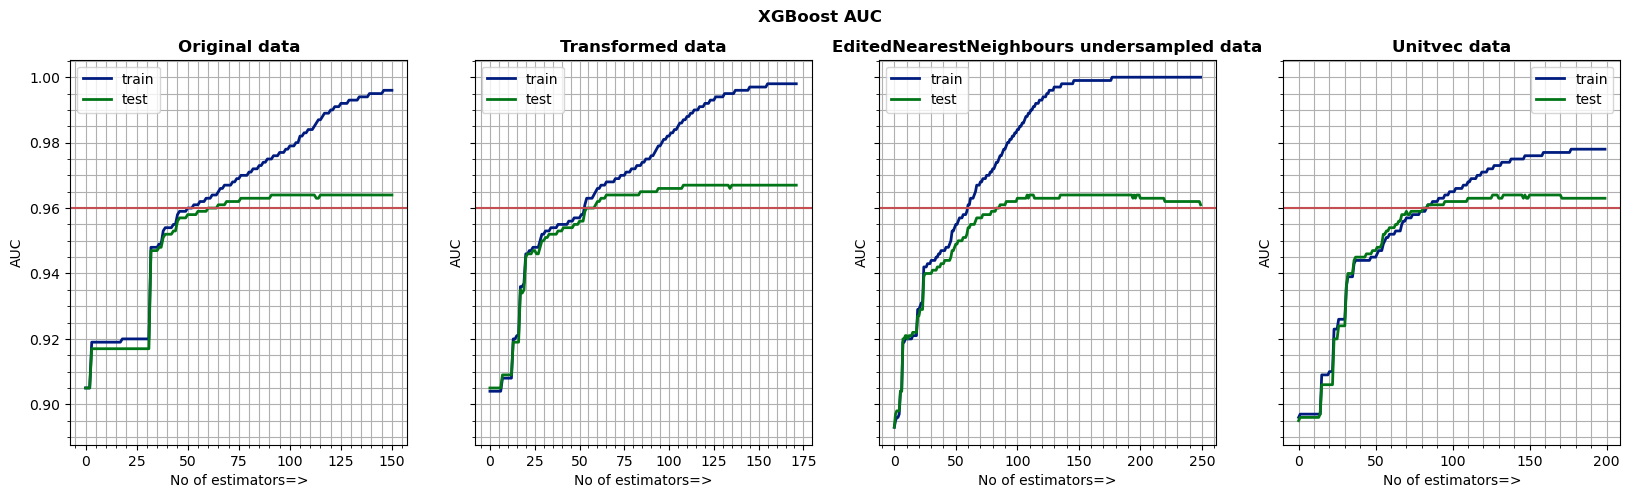

In [249]:
# 30.3 Learning curve

plt.style.use('seaborn-v0_8-dark-palette')
# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,4, figsize = (20,5), sharey = True);

results = [model_orig.evals_result(),model_trans.evals_result(), model_en.evals_result(), model_vec.evals_result() ]
title = ["Original data", 'Transformed data', 'EditedNearestNeighbours undersampled data', 'Unitvec data']
fig.suptitle("XGBoost AUC", fontweight = "bold")

for i in range(4):
    epochs = len(results[i]['validation_0']['auc'])
    x_axis = range(0,epochs)
    ax[i].plot(x_axis, np.round(results[i]['validation_0']['auc'],3),linewidth=2, label='train');
    ax[i].plot(x_axis, np.round(results[i]['validation_1']['auc'],3), linewidth=2, label='test');
    ax[i].legend();
    ax[i].grid(visible = True, which = 'both');
    ax[i].minorticks_on();
    ax[i].set_ylabel('AUC');
    ax[i].set_xlabel("No of estimators=>")
    ax[i].set_title(title[i], fontsize = 12, fontweight = "bold");
    ax[i].axhline(y = 0.96, color = 'r', linestyle = '-')

plt.show();




### Horizontally concatenate to pca data rem cols

In [12]:
# 31 Now horizontally concatenate:

cctr_rem = pd.concat([X_train[rem_cols], cctr],  axis = 1)
ccte_rem = pd.concat([X_test[rem_cols], ccte], axis = 1)
                           
# 31.1 Check
cctr_rem.shape  # (3000806, 137)/(3002043, 21)/(3001476, 21)/(2998791, 21)/(3747190, 21)
ccte_rem.shape   # (3000806, )/(1000682, 21)/(1000493, 21)/(999597, 21)/(1249064, 21)

(3747190, 21)

(1249064, 21)

In [13]:
## xgboost modeling of above concatenated data

# 31.2 Perform xgboost modeling using the above pca_train_trans/pca_test_trans data:

model_vec_full = xgb.XGBClassifier( n_estimators= 250,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 14,
                              subsample = 0.9,
                              random_state = rng,
                              reg_lambda = 1.5,
                           )


tr_X =    cctr_rem
test_X =  ccte_rem
ytrain =  y_train
ytest = y_test


model_vec_full.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )




[18:35:40] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[18:35:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1088 extra nodes, 0 pruned nodes, max_depth=14
[0]	validation_0-auc:0.89604	validation_1-auc:0.89493
[18:35:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 932 extra nodes, 0 pruned nodes, max_depth=14
[1]	validation_0-auc:0.89608	validation_1-auc:0.89496
[18:35:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1000 extra nodes, 0 pruned nodes, max_depth=14
[2]	validation_0-auc:0.89610	validation_1-auc:0.89496
[18:35:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1060 extra nodes, 0 pruned nodes, max_depth=14
[3]	validation_0-auc:0.89726	valid

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=14,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [14]:
# 31.3 Save model object:

utils.savePythonObject(model_vec_full, "model_vec_full.pkl", talkingdataestimators)

Object saved to: D:\talkingdata\allmodels\estimators\model_vec_full.pkl


In [15]:
# 31.4 Rstore model object:

model_vec_full = utils.restorePythonObject("model_vec_full.pkl", talkingdataestimators)

In [16]:
# 31.5 Best scores with 'ip' and datetime related columns:

model_vec_full.best_score   # 0.9658114/0.96369714/0.961902744/0.957092431030187
print("\n")
model_vec_full.best_iteration  # 141/180/105/100/117

0.9671532570820001

162

In [17]:
# 31.6 Classification report with 'ip' and datetime related columns::

pred_vec_full = model_vec_full.predict(test_X)
uvec_cl_ip=classification_report(ytest,pred_vec_full)
print(uvec_cl_ip)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1245963
           1       0.75      0.35      0.47      3101

    accuracy                           1.00   1249064
   macro avg       0.87      0.67      0.74   1249064
weighted avg       1.00      1.00      1.00   1249064



In [ ]:
 """
    
                precision    recall  f1-score   support

           0       1.00      1.00      1.00    997845
           1       0.77      0.36      0.49      2424

    accuracy                           1.00   1000269
   macro avg       0.88      0.68      0.75   1000269
weighted avg       1.00      1.00      1.00   1000269


               precision    recall  f1-score   support

           0       1.00      1.00      1.00    998259
           1       0.74      0.34      0.46      2423

    accuracy                           1.00   1000682
   macro avg       0.87      0.67      0.73   1000682
weighted avg       1.00      1.00      1.00   1000682

               precision    recall  f1-score   support

           0       1.00      1.00      1.00    998061
           1       0.75      0.36      0.49      2432

    accuracy                           1.00   1000493
   macro avg       0.88      0.68      0.75   1000493
weighted avg       1.00      1.00      1.00   1000493

                 precision    recall  f1-score   support

           0       1.00      1.00      1.00    997124
           1       0.76      0.33      0.46      2473

    accuracy                           1.00    999597
   macro avg       0.88      0.67      0.73    999597
weighted avg       1.00      1.00      1.00    999597






"""

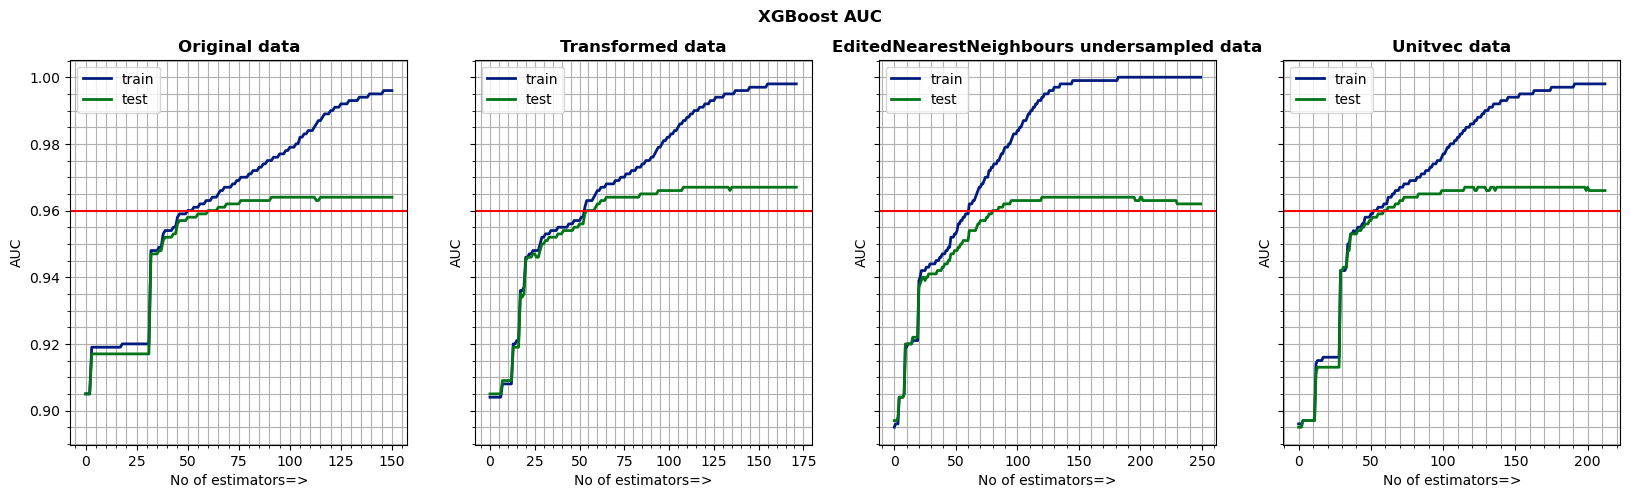

In [26]:
# 30.3 Learning curve

plt.style.use('seaborn-v0_8-dark-palette')
# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,4, figsize = (20,5), sharey = True);

results = [model_orig.evals_result(),model_trans.evals_result(), model_en.evals_result(), model_vec_full.evals_result() ]
title = ["Original data", 'Transformed data', 'EditedNearestNeighbours undersampled data', 'Unitvec data']
fig.suptitle("XGBoost AUC", fontweight = "bold")

for i in range(4):
    epochs = len(results[i]['validation_0']['auc'])
    x_axis = range(0,epochs)
    ax[i].plot(x_axis, np.round(results[i]['validation_0']['auc'],3),linewidth=2, label='train');
    ax[i].plot(x_axis, np.round(results[i]['validation_1']['auc'],3), linewidth=2, label='test');
    ax[i].legend();
    ax[i].grid(visible = True, which = 'both');
    ax[i].minorticks_on();
    ax[i].set_ylabel('AUC');
    ax[i].set_xlabel("No of estimators=>")
    ax[i].set_title(title[i], fontsize = 12, fontweight = "bold");
    ax[i].axhline(y = 0.96, color = 'r', linestyle = '-')

plt.show();




In [ ]:
##*****************************
## Embedding Projector

##*****************************

In [260]:
# 33
# 33.1 Get target data col. Needed for generation of meta-data file:


train_trans['target'] =  y_train

vec_tr_mean,_ = ct.vectorsToTSV(train_trans,
                           take_mean = True,
                           filepath = talkingdataunitvecs,   # Folder where csv files will be saved
                           saveVectorsToDisk = True,
                           fnamesuffix = "_avged"     
                           )



Checking if vectors exist for all cat cols...
May take time...
Checked for app
Checked for device
Checked for os
Checked for channel
Saved files are named as '<catColname>.tsv' and '<catColname_meta>.tsv'
You will find them in folder: 'D:\talkingdata\allmodels\unitvec'
Load these file-pairs in tensorflow's 'Embedding Projector'
It helps in visualizing interrelationships among levels of a categorical feature


## Feature Engineering through clustering

In [261]:
# 34.0 Create clustering features from unitvector dataframes:

n_components = 4  # No of components while performing PCA of every feature
fe_tr,fe_te = utils.featureEngKmeans(cctr,
                                     ccte,
                                     n_clusters = 12,  # No of clusters per feature
                                     step_size = n_components,
                                     km=True,  # Only perform KMeans
                                     gmm=False  # No Gaussian Mixture modeling
                                     )

Current index:  0
Current index:  4
Current index:  8
Current index:  12


In [262]:
# 34.1 Output is orig dataframe + clusters
fe_tr.head(3)
fe_te.head(3)

,pcapp0,pcapp1,pcapp2,pcapp3,pcdevice0,pcdevice1,pcdevice2,pcdevice3,pcos0,pcos1,pcos2,pcos3,pcchannel0,pcchannel1,pcchannel2,pcchannel3,clu0,clu1,clu2,clu3
0,3.671103,-0.865406,-3.050680,0.368654,-0.398636,0.787238,-0.200491,0.136411,-1.280446,0.294047,-1.937024,0.671268,-0.435268,-4.143646,0.843768,1.534261,5,0,1,5
1,-0.507002,5.354653,1.565948,-1.754986,-0.407465,0.640545,0.203725,-0.024267,-1.244083,0.230523,-1.406424,0.218394,4.800220,-3.767235,-0.564055,1.484366,6,0,1,9
2,-1.717272,0.717173,-0.062780,2.593551,-0.407952,0.641808,0.018090,-0.353882,-1.279417,0.218141,-1.871620,0.501109,-0.497745,-0.122144,-1.385875,0.130813,8,0,1,2


,pcapp0,pcapp1,pcapp2,pcapp3,pcdevice0,pcdevice1,pcdevice2,pcdevice3,pcos0,pcos1,pcos2,pcos3,pcchannel0,pcchannel1,pcchannel2,pcchannel3,clu0,clu1,clu2,clu3
0,-0.808483,-1.538319,-0.429401,-0.367411,0.147834,-11.889017,2.163232,0.132562,-1.244024,0.229337,-1.415404,0.202054,-2.829218,1.087118,0.843500,-1.472553,10,2,1,3
1,-1.543873,-3.447913,1.313072,2.381807,-0.407763,0.641912,-0.019017,-0.014087,-1.244024,0.229337,-1.415404,0.202054,-0.588555,-1.348168,-0.291152,-0.288995,4,0,1,2
2,-3.865766,-0.401923,1.810693,-2.645520,-0.407763,0.641912,-0.019017,-0.014087,0.438189,-0.555378,1.507220,-0.226979,-3.164828,0.564920,-1.335926,-1.086098,3,0,0,0


In [263]:
# 34.2 Have a look at clusters created:

fe_tr[fe_tr.columns[-len(cat_cols):]].head()
fe_te[fe_te.columns[-len(cat_cols):]].head()

,clu0,clu1,clu2,clu3
0,5,0,1,5
1,6,0,1,9
2,8,0,1,2
3,11,2,10,2
4,2,0,1,10


,clu0,clu1,clu2,clu3
0,10,2,1,3
1,4,0,1,2
2,3,0,0,0
3,11,0,9,0
4,2,0,7,2


In [264]:
# 34.3
model_fe = xgb.XGBClassifier( n_estimators= 200,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 13,
                              subsample = 0.9,
                              random_state = None,
                              reg_lambda = 1.5,
                           )

tr_X =   fe_tr[fe_tr.columns[-len(cat_cols):]]
test_X =  fe_te[fe_te.columns[-len(cat_cols):]]
ytrain =  y_train
ytest = y_test


model_fe.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )

[09:33:23] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[09:33:23] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.77322	validation_1-auc:0.77211
[09:33:24] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.77322	validation_1-auc:0.77212
[09:33:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=12
[2]	validation_0-auc:0.77326	validation_1-auc:0.77214
[09:33:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=11
[3]	validation_0-auc:0.77327	validation_1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [268]:
# 34.4 Save model object:

utils.savePythonObject(model_fe, "model_fe.pkl", talkingdataestimators)

Object saved to: D:\talkingdata\allmodels\estimators\model_fe.pkl


In [269]:
# 34.5 Restore model object:

model_fe = utils.restorePythonObject("model_fe.pkl", talkingdataestimators)

In [270]:
# 34.6


model_fe.best_score  # 0.938681430882942

0.9386814308829429

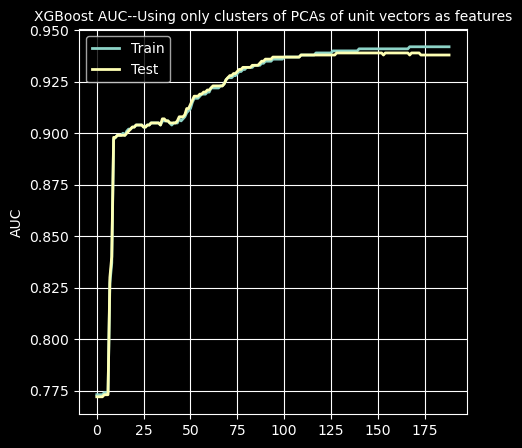

In [266]:
# 34.7 Learning curve

# Ref: https://stackoverflow.com/a/60366515
plt.style.use("dark_background")
plt.figure(figsize = (5,5));
results = model_fe.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
plt.legend();
plt.grid()
plt.ylabel('AUC');
plt.title("XGBoost AUC--Using only clusters of PCAs of unit vectors as features", fontsize = 10);

     

In [ ]:
###################Done##################

In [ ]:
#### ROUGH WORK ##########
#### ROUGH WORK ##########

In [267]:
gc.collect()

4284

In [65]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

In [66]:
r1= cctr.astype(np.float16)
pca_train_unit, _, y_train_unit, _ = train_test_split(r1,y_train, train_size = 30000, stratify = y_train)

In [67]:
pca_train_unit.shape  # (20000, 16)
y_train_unit.shape   # (20000, )
y_train_unit.sum()   # 49
pca_train_unit.dtypes

(30000, 16)

(30000,)

73

pcapp0        float16
pcapp1        float16
pcapp2        float16
pcapp3        float16
pcdevice0     float16
pcdevice1     float16
pcdevice2     float16
pcdevice3     float16
pcos0         float16
pcos1         float16
pcos2         float16
pcos3         float16
pcchannel0    float16
pcchannel1    float16
pcchannel2    float16
pcchannel3    float16
dtype: object

In [68]:
ex1 = pca_train_unit.iloc[:, 0:4]
ex2 = pca_train_unit.iloc[:,4:8]
ex3 = pca_train_unit.iloc[:,8:12]
ex4 = pca_train_unit.iloc[:,12:16]
gc.collect()

72

In [69]:
gc.collect()

0

In [70]:
x1 = cosine_similarity(ex1)
x2 = cosine_similarity(ex2)
x3 = cosine_similarity(ex3)
x4 = cosine_similarity(ex4)

In [71]:
x1.shape
x2.shape
x3.shape
x4.shape

(30000, 30000)

(30000, 30000)

(30000, 30000)

(30000, 30000)

In [72]:
kmeans1 = KMeans(n_clusters = 20)
kmeans2 = KMeans(n_clusters = 20)
kmeans3 = KMeans(n_clusters = 20)
kmeans4 = KMeans(n_clusters = 20)


In [73]:
kx1 = kmeans1.fit_transform(x1)
print("d1")
gc.collect()
kx2 = kmeans2.fit_transform(x2)
print("d2")
kx3 = kmeans3.fit_transform(x3)
print("d3")
kx4 = kmeans4.fit_transform(x4)
print("d4")
gc.collect()

d1


183

d2
d3
d4


150

In [74]:
gc.collect()

0

In [11]:
# 26.1 A quick readback all saved files

train_trans = pd.read_pickle(Path(talkingdatadata) / "train_trans.pkl")
test_trans = pd.read_pickle(Path(talkingdatadata) / "test_trans.pkl")
X_train = pd.read_pickle(Path(talkingdatadata) / "X_train.pkl")
X_test = pd.read_pickle(Path(talkingdatadata) / "X_test.pkl")
y_train = pd.read_pickle(Path(talkingdatadata) / "y_train.pkl")
y_test = pd.read_pickle(Path(talkingdatadata) / "y_test.pkl")


# 26.2.1 Reindex X_train/X_test

X_train = X_train.reset_index( drop = True )
X_test = X_test.reset_index(drop = True)

# 26.2.2 Check
train_trans.head(2)
test_trans.head(2)
X_train.head(2)
X_test.head(2)

# 26.2.3
train_trans.shape   # (3000806, 136)/(3002043, 136)/(3001476, 136)
y_train.shape       # (3000806, )/(3002043, )/(3001476, )
test_trans.shape    # (1000269, 136)/(1000682, 136)/(1000493, 136)
y_test.shape        # (1000269, )/(1000682, )/(1000493, )


# 26.2.4 Our cat cols
cat_cols = ['app', 'device', 'os', 'channel']  # 4cols

# 26.2.5 Remaining cols not treated as cat cols:
rem_cols = {'ip', 'minute', 'day', 'hour', 'second'} # 5 cols


# 26.3 Concat rem_cols with transformed data:

# 26.4 Columns after transformeation to be considered. Ignore initial cat_cols
cols = train_trans.columns[len(cat_cols):]

# 26.5 Now horizontally concatenate:
X_train_trans = pd.concat([X_train[rem_cols], train_trans[cols] ],  axis = 1)
X_test_trans = pd.concat([X_test[rem_cols], test_trans[cols] ], axis = 1)
                           
# 26.6 Check
X_train_trans.shape  # (3000806, 137)/(3002043, 137)/(3001476, 137)
X_test_trans.shape   # (3000806, )/(1000682, 137)/(1000493, 137)



,app,device,os,channel,deg_app_ck_device,eig_app_ck_device,pr_app_ck_device,clu_app_ck_device,bet_app_ck_device,deg_app_ck_os,...,deg_channel_ck_device_p_os,eig_channel_ck_device_p_os,pr_channel_ck_device_p_os,clu_channel_ck_device_p_os,bet_channel_ck_device_p_os,deg_channel_ck_app_p_os,eig_channel_ck_app_p_os,pr_channel_ck_app_p_os,clu_channel_ck_app_p_os,bet_channel_ck_app_p_os
0,13,1,13,477,0.809917,0.076224,0.003801,0.697174,0.002960,0.834711,...,0.971591,0.077525,0.005920,0.970210,0.000757,0.164773,3.902822e-02,0.004952,0.633005,0.004242
1,22,1,19,116,0.779614,0.074330,0.003666,0.717791,0.002223,0.834711,...,0.960227,0.077257,0.005838,0.986616,0.000093,0.005682,2.230271e-17,0.004544,0.000000,0.000000


,app,device,os,channel,deg_app_ck_device,eig_app_ck_device,pr_app_ck_device,clu_app_ck_device,bet_app_ck_device,deg_app_ck_os,...,deg_channel_ck_device_p_os,eig_channel_ck_device_p_os,pr_channel_ck_device_p_os,clu_channel_ck_device_p_os,bet_channel_ck_device_p_os,deg_channel_ck_app_p_os,eig_channel_ck_app_p_os,pr_channel_ck_app_p_os,clu_channel_ck_app_p_os,bet_channel_ck_app_p_os
0,3,2,19,280,0.809917,0.076224,0.003801,0.697174,0.002960,0.837466,...,0.977273,0.077637,0.005963,0.961648,0.000865,0.397727,0.121408,0.009006,0.604141,0.008494
1,15,1,19,245,0.768595,0.073619,0.003617,0.724014,0.002355,0.834711,...,0.965909,0.077355,0.005884,0.977445,0.000694,0.289773,0.074779,0.006935,0.657255,0.003071


,ip,app,device,os,channel,day,hour,minute,second
0,128686,13,1,13,477,7,4,8,30
1,55146,22,1,19,116,9,12,30,0


,ip,app,device,os,channel,day,hour,minute,second
0,44961,3,2,19,280,7,1,42,4
1,62900,15,1,19,245,8,20,18,33


(3747190, 136)

(3747190,)

(1249064, 136)

(1249064,)

(3747190, 137)

(1249064, 137)

In [76]:
 kmeans1.labels_

array([ 5,  6, 14, ..., 13,  4,  0])

In [77]:
pca_train_unit["k1"] = kmeans1.labels_
pca_train_unit["k2"] = kmeans2.labels_
pca_train_unit["k3"] = kmeans3.labels_
pca_train_unit["k4"] = kmeans4.labels_


In [78]:
pca_train_unit.shape

(30000, 20)

In [110]:
tr, te, ytr,yte = train_test_split(pca_train_unit,y_train_unit, test_size = 0.25, stratify = y_train_unit)

In [113]:
## xgboost modeling of above concatenated data

# 31.2 Perform xgboost modeling using the above pca_train_trans/pca_test_trans data:
del mkm
mkm = xgb.XGBClassifier( n_estimators= 100,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 11,
                              #subsample = 0.8,
                              random_state = rng,
                             
                           )

## NOTE THIS IS WITH 'ip' and other numeric columns
tr_X =    tr.iloc[:,-4:]
test_X =  te.iloc[:,-4:]
ytrain =  ytr
ytest = yte


mkm.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )




[13:21:54] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[13:21:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[0]	validation_0-auc:0.56304	validation_1-auc:0.49920
[13:21:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[1]	validation_0-auc:0.56304	validation_1-auc:0.49920
[13:21:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[2]	validation_0-auc:0.56304	validation_1-auc:0.49920
[13:21:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[3]	validation_0-auc:0.56304	validation_1-auc:0.4

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=11,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [112]:
# 31.4 Classification report with 'ip' and datetime related columns::

pred_te = mkm.predict(test_X)
stp=classification_report(yte,pred_te)
print(stp)



              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7482
           1       0.00      0.00      0.00        18

    accuracy                           1.00      7500
   macro avg       0.50      0.50      0.50      7500
weighted avg       1.00      1.00      1.00      7500



In [105]:
## Rough
gc.collect()

22244

In [41]:
from imblearn.under_sampling import RepeatedEditedNearestNeighbours, RandomUnderSampler, NearMiss,OneSidedSelection

In [13]:
from imblearn.under_sampling import RepeatedEditedNearestNeighbours, RandomUnderSampler
start = time.time()
renn = RepeatedEditedNearestNeighbours(max_iter = 3)
X_res, y_res = renn.fit_resample(pca_train, y_train)
end = time.time()
print((end-start)/60)  # 348 min


347.540420905749


In [14]:
X_res.shape  # (3734643, 25)

(3734643, 25)

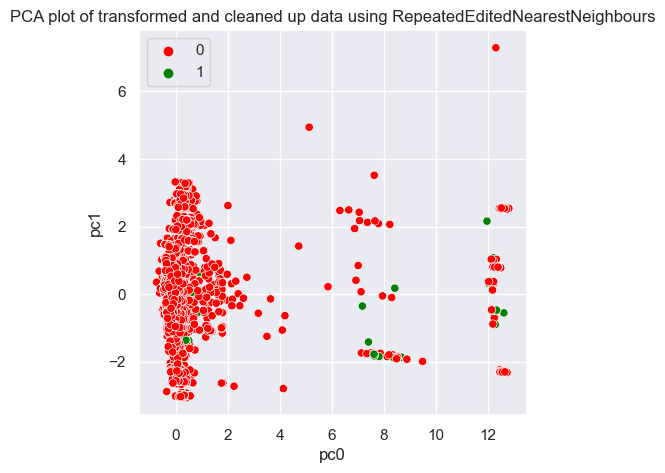

In [17]:
# 18.0.3 2D PCA plot from first two principal components:
#         First take a stratified sample for plotting
#         And then plot:

_, pca_tr, _,pca_y  = train_test_split(X_res, y_res, test_size = 50000, stratify = y_res)
#pca_tr= X_res # (50000, 26)
#pca_y= y_res   # (5000,)

pca_tr.shape


fig = plt.figure(figsize = (5,5));
fig.add_subplot(1,1,1);
sns.set_theme() ; 
sns.scatterplot(data = pca_tr,  # Sample of 5000
                x=  'pc0',
                y = 'pc1',
                hue = pca_y.values,
                palette = ["red", "green"]
                ).set(title='PCA plot of transformed and cleaned up data using RepeatedEditedNearestNeighbours') ;

In [16]:
gc.collect()

301

In [18]:
# 19.0 Modeling with smoteenn data (without ip and rem features)

model_ren = xgb.XGBClassifier( n_estimators= 200,
                               verbosity = 3,
                               eta = 0.06,     
                               max_depth = 12,
                               subsample = 0.8,          
                               random_state = rng,
                           )


tr_X =   X_res 
test_X = pca_test
ytrain = y_res 
ytest =  y_test


model_ren.fit(tr_X, ytrain.values,                  
                early_stopping_rounds = 50,   
                eval_set=[(tr_X, ytrain.values), (test_X, ytest.values)],
                eval_metric = ['auc']    
                )



[15:23:56] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[15:24:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 962 extra nodes, 0 pruned nodes, max_depth=12
[0]	validation_0-auc:0.89171	validation_1-auc:0.88313
[15:24:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 852 extra nodes, 0 pruned nodes, max_depth=12
[1]	validation_0-auc:0.89457	validation_1-auc:0.88615
[15:24:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 868 extra nodes, 0 pruned nodes, max_depth=12
[2]	validation_0-auc:0.89564	validation_1-auc:0.88692
[15:24:19] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 862 extra nodes, 0 pruned nodes, max_depth=12
[3]	validation_0-auc:0.89602	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=12,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [20]:
# 31.4 Classification report with 'ip' and datetime related columns::

pred_ren = model_ren.predict(test_X)
stp=classification_report(y_test,pred_ren)
print(stp)



              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1247914
           1       0.48      0.59      0.53      3116

    accuracy                           1.00   1251030
   macro avg       0.74      0.79      0.76   1251030
weighted avg       1.00      1.00      1.00   1251030



In [42]:
rus = OneSidedSelection()

X_res, y_res = rus.fit_resample(pca_train, y_train)

In [43]:
X_res.shape  # (3740358, 25)

(3740358, 25)

In [44]:
# 19.0 Modeling with smoteenn data (without ip and rem features)

model_rus = xgb.XGBClassifier( n_estimators= 200,
                               verbosity = 3,
                               eta = 0.06,     
                               max_depth = 12,
                               subsample = 0.8,          
                               random_state = rng,
                           )


tr_X =   X_res 
test_X = pca_test
ytrain = y_res 
ytest =  y_test


model_rus.fit(tr_X, ytrain.values,                  
                early_stopping_rounds = 50,   
                eval_set=[(tr_X, ytrain.values), (test_X, ytest.values)],
                eval_metric = ['auc']    
                )



[05:28:01] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[05:28:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1190 extra nodes, 0 pruned nodes, max_depth=12
[0]	validation_0-auc:0.89133	validation_1-auc:0.88401
[05:28:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1080 extra nodes, 0 pruned nodes, max_depth=12
[1]	validation_0-auc:0.89186	validation_1-auc:0.88459
[05:28:19] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1120 extra nodes, 0 pruned nodes, max_depth=12
[2]	validation_0-auc:0.89220	validation_1-auc:0.88460
[05:28:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1126 extra nodes, 0 pruned nodes, max_depth=12
[3]	validation_0-auc:0.89498	vali

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=12,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [45]:
# 31.4 Classification report with 'ip' and datetime related columns::

pred_rus = model_rus.predict(test_X)
cl_rus=classification_report(y_test,pred_rus)
print(cl_rus)



              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1247914
           1       0.68      0.40      0.51      3116

    accuracy                           1.00   1251030
   macro avg       0.84      0.70      0.75   1251030
weighted avg       1.00      1.00      1.00   1251030

